# 📘 Two-Wheeler Demand Forecasting
**Author:** Fotis Diamantidis <br>
**Goal:** Predict daily two-wheeler (scooter + bicycle + moped) demand.

# 1. Importing Libraries

In [1]:
# Core Python & Data Libraries
import os
import random
import time
import json
import pickle
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# PyTorch (Deep Learning)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset

# Scikit-Learn (Preprocessing)
from sklearn.preprocessing import StandardScaler

# Progress bar
from tqdm import tqdm

# Scipy for statistical tests
from scipy import stats

# Reproducibility Helper
def set_seed(seed=42):
    """Fix random seeds for reproducibility (CPU-only)."""
    random.seed(seed)          # For Python’s random module
    np.random.seed(seed)       # For NumPy random ops
    torch.manual_seed(seed)    # For PyTorch (CPU ops)
    os.environ["PYTHONHASHSEED"] = str(seed)  # Makes hashing deterministic

# Set seed globally
set_seed(42)

# 2. Loading the Dataset

In [2]:
# Configure data Types for the DataFrame creation. Integers are left out because NaNs generate an error.
dtypes = {
    'ID': 'string',
    'Device ID': 'string',
    'Vehicle Type': 'category',
    'Start Time': 'string',
    'End Time': 'string',
    'Modified Date': 'string',
    'Month': 'Int8',
    'Day of Week': 'Int8',
    'Year': 'Int16',
    'Council District Start': 'string',
    'Council District End': 'string',
    'Census Tract Start': 'string',
    'Census Tract End': 'string',
    # Not forcing dtypes for Trip Duration / Trip Distance here
}

# Configure ID as the index column.
index_cols = ['ID']

# Create the dataframe.
df = pd.read_csv("data/raw/Shared_Micromobility_Vehicle_Trips_2018-2022.csv", dtype=dtypes, low_memory=False, thousands=",")

#Save the original dataframe for comparison after cleaning the data for comparison purposes.
df_raw = df.copy()

# Use describe to search for outliers
df.describe()

,Trip Duration,Trip Distance,Month,Hour,Day of Week,Council District (Start),Council District (End),Year (US/Central)
count,1.504864e+07,1.504864e+07,15048635.0,1.504864e+07,15048635.0,1.502844e+07,1.502712e+07,1.504864e+07
mean,7.150060e+02,2.825117e+04,6.713849,1.266304e+01,3.497204,7.675822e+00,7.603119e+00,2.019657e+03
std,5.803378e+03,4.705075e+06,3.342199,8.310150e+00,2.036327,2.621605e+00,2.670329e+00,1.201316e+00
min,-8.616100e+04,-5.243139e+08,1.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.970000e+03
25%,2.390000e+02,4.960000e+02,4.0,4.000000e+00,2.0,9.000000e+00,9.000000e+00,2.019000e+03
50%,4.280000e+02,1.093000e+03,7.0,1.600000e+01,4.0,9.000000e+00,9.000000e+00,2.019000e+03
75%,8.020000e+02,2.075000e+03,10.0,2.000000e+01,5.0,9.000000e+00,9.000000e+00,2.021000e+03
max,1.548558e+07,2.239711e+09,12.0,2.300000e+01,6.0,1.000000e+01,1.000000e+01,2.022000e+03


# 3. Data Filtering & Cleaning

In [3]:
# 1. Save the initial number of rows before any cleaning
initial_rows = len(df)
df.columns = df.columns.str.strip()

# 1) Robust parsing Start/End Time
def parse_datetimes(series, fmts):
    s_raw = series.astype(str).str.strip()
    out = pd.Series(pd.NaT, index=series.index)
    for fmt in fmts:
        mask = out.isna()
        if not mask.any():
            break
        out.loc[mask] = pd.to_datetime(s_raw[mask], format=fmt, errors='coerce')
    mask = out.isna()
    if mask.any():
        out.loc[mask] = pd.to_datetime(s_raw[mask], errors='coerce', infer_datetime_format=True)
    return out

CANDIDATE_FORMATS = [
    '%m/%d/%Y %I:%M:%S %p',
    '%Y %b %d %I:%M:%S %p',
    '%Y-%m-%d %H:%M:%S',
    '%d/%m/%Y %H:%M',
]

df['Start Time'] = parse_datetimes(df['Start Time'], CANDIDATE_FORMATS)
df['End Time'] = parse_datetimes(df['End Time'], CANDIDATE_FORMATS)

# 1a) Count invalid
invalid_datetime_rows = df[['Start Time','End Time']].isna().any(axis=1).sum()

# 1b) Drop invalid datetimes
df = df.dropna(subset=['Start Time', 'End Time'])

# 2) Vehicle filter
before_vehicle = len(df)
df['Vehicle Type'] = df['Vehicle Type'].astype(str).str.strip().str.lower()

# Choose which vehicle type to keep
VEHICLE_TYPE = 'scooter'  # Options: 'scooter', 'bicycle', 'moped'

df = df[df['Vehicle Type'] == VEHICLE_TYPE]
print(f"✅ Filtered for {VEHICLE_TYPE.upper()} only.")
vehicle_rows_removed = before_vehicle - len(df)

if df.empty:
    raise ValueError(f"No data found for vehicle type '{VEHICLE_TYPE}'. Please check your dataset.")

# 3) OUT_OF_BOUNDS
oob_cols = [c for c in ['Census Tract Start','Census Tract End'] if c in df.columns]
if len(oob_cols) == 2:
    oob_mask = (
        df['Census Tract Start'].astype(str).str.contains('OUT_OF_BOUNDS', na=False) |
        df['Census Tract End'  ].astype(str).str.contains('OUT_OF_BOUNDS', na=False)
    )
    out_of_bounds_rows = int(oob_mask.sum())
    df = df[~oob_mask]
else:
    out_of_bounds_rows = 0

# 4) Numeric coercion
for col in ['Trip Duration','Trip Distance']:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False).str.strip()
    df[col] = pd.to_numeric(df[col], errors='coerce')

before_na = len(df)
df = df.dropna(subset=['Trip Duration','Trip Distance'])
na_rows_removed = before_na - len(df)

# 5) Outliers
before_outliers = len(df)
MAX_DURATION_SEC = 43200      # 12 hours
MAX_DISTANCE_M = 80467.2    # ~50 miles
df = df[(df['Trip Duration'] > 0) & (df['Trip Duration'] <= MAX_DURATION_SEC)]
df = df[(df['Trip Distance'] > 0) & (df['Trip Distance'] <= MAX_DISTANCE_M)]
after_outliers = len(df)
outlier_rows_removed = before_outliers - after_outliers

# 6) Datetime features
df['Date']       = df['Start Time'].dt.date
df['Hour']       = df['Start Time'].dt.hour
df['DayOfWeek']  = df['Start Time'].dt.dayofweek
df['Month']      = df['Start Time'].dt.month

# Map months to seasons (0–3)
def month_to_season(month):
    if month in [12, 1, 2]:
        return 0  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Autumn

df['Season'] = df['Month'].apply(month_to_season)

# 7) Final stats
final_rows = len(df)
rows_removed = initial_rows - final_rows

✅ Filtered for SCOOTER only.


# 4. Post-Cleaning Validation
## 4.1 Data Cleaning Report

In [4]:
print("🔍 Data Cleaning Report")
print("-" * 40)
print(f"Initial number of rows: {initial_rows:,}")
print(f"Final number of rows: {final_rows:,}")
print(f"Total rows removed: {rows_removed:,}")
print(f"1. Removed invalid datetime rows (Start/End Time): {invalid_datetime_rows:,}")
print(f"2. Removed 'OUT_OF_BOUNDS' location rows: {out_of_bounds_rows:,}")
print(f"3. Removed NaN rows (Trip Duration/Distance coercion): {na_rows_removed:,}")
print(f"4. Removed outlier rows (Duration & Distance): {outlier_rows_removed:,}")
print(f"Date range: {df['Start Time'].min().date()} to {df['Start Time'].max().date()}")
print(f"Number of unique days: {df['Date'].nunique():,}")
print(f"\nSelected vehicle type: {VEHICLE_TYPE.upper()}")
print(f"Total trips: {len(df):,}")

🔍 Data Cleaning Report
----------------------------------------
Initial number of rows: 15,048,635
Final number of rows: 13,450,269
Total rows removed: 1,598,366
1. Removed invalid datetime rows (Start/End Time): 0
2. Removed 'OUT_OF_BOUNDS' location rows: 53,821
3. Removed NaN rows (Trip Duration/Distance coercion): 0
4. Removed outlier rows (Duration & Distance): 881,676
Date range: 2018-04-03 to 2022-04-04
Number of unique days: 1,440

Selected vehicle type: SCOOTER
Total trips: 13,450,269


## 4.2 Visual Comparison: Before vs After Data Cleaning

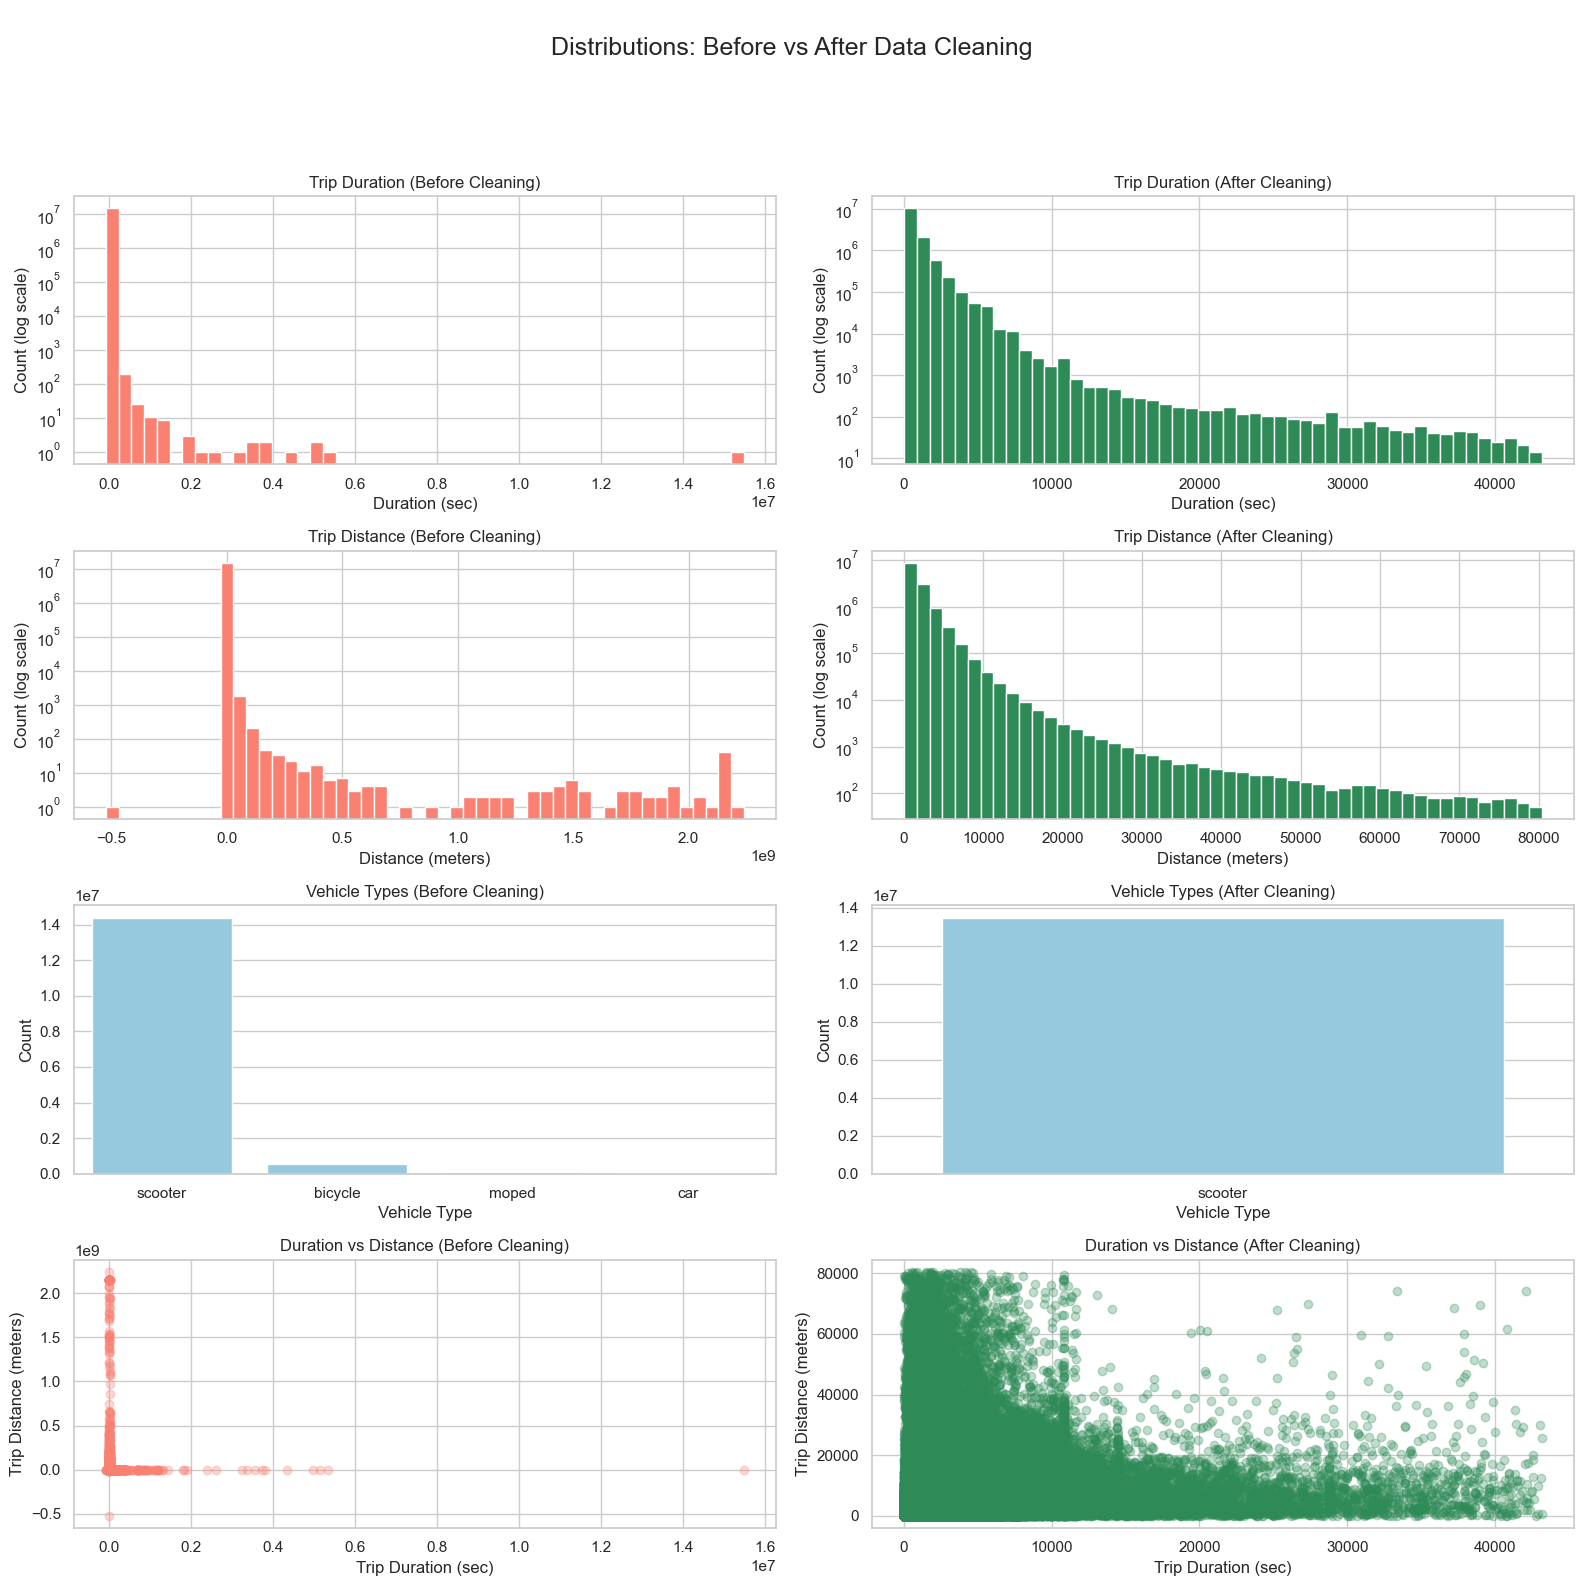

In [5]:
# Set visual style
sns.set(style="whitegrid")

# Normalize vehicle type labels for clearer before/after plots
df_raw['Vehicle Type'] = df_raw['Vehicle Type'].astype(str).str.strip().str.lower()
type_order = ['scooter', 'bicycle', 'moped', 'car']

# Create subplot grid: 4 rows x 2 columns
fig, axs = plt.subplots(4, 2, figsize=(16, 16))
fig.suptitle('\nDistributions: Before vs After Data Cleaning', fontsize=18, y=1.02)

# --- Trip Duration ---
# Question: Μετά τον καθαρισμό, σε ποια διάρκεια (sec) συγκεντρώνεται η πλειοψηφία των ταξιδιών;
axs[0, 0].hist(df_raw['Trip Duration'], bins=50, log=True, color='salmon')
axs[0, 0].set_title('Trip Duration (Before Cleaning)')
axs[0, 0].set_xlabel('Duration (sec)')
axs[0, 0].set_ylabel('Count (log scale)')

axs[0, 1].hist(df['Trip Duration'], bins=50, log=True, color='seagreen')
axs[0, 1].set_title('Trip Duration (After Cleaning)')
axs[0, 1].set_xlabel('Duration (sec)')
axs[0, 1].set_ylabel('Count (log scale)')

# --- Trip Distance ---
# Question: Μετά το φιλτράρισμα, ποια είναι η τυπική απόσταση για την οποία χρησιμοποιούνται τα δίτροχα;
axs[1, 0].hist(df_raw['Trip Distance'], bins=50, log=True, color='salmon')
axs[1, 0].set_title('Trip Distance (Before Cleaning)')
axs[1, 0].set_xlabel('Distance (meters)')
axs[1, 0].set_ylabel('Count (log scale)')

axs[1, 1].hist(df['Trip Distance'], bins=50, log=True, color='seagreen')
axs[1, 1].set_title('Trip Distance (After Cleaning)')
axs[1, 1].set_xlabel('Distance (meters)')
axs[1, 1].set_ylabel('Count (log scale)')

# --- Vehicle Type ---
# Question: Ποια είναι η τελική κατανομή του στόλου μας μετά το φιλτράρισμα;
sns.countplot(x='Vehicle Type', data=df_raw, order=type_order, ax=axs[2, 0], color='skyblue')
axs[2, 0].set_title('Vehicle Types (Before Cleaning)')
axs[2, 0].set_ylabel('Count')

sns.countplot(x='Vehicle Type', data=df, ax=axs[2, 1], color='skyblue')
axs[2, 1].set_title('Vehicle Types (After Cleaning)')
axs[2, 1].set_ylabel('Count')

# --- Duration vs Distance ---
# Question: Μετά τον καθαρισμό, ποια είναι η τελική, υγιής συσχέτιση μεταξύ διάρκειας και απόστασης;
axs[3, 0].scatter(df_raw['Trip Duration'], df_raw['Trip Distance'], alpha=0.3, color='salmon')
axs[3, 0].set_title('Duration vs Distance (Before Cleaning)')
axs[3, 0].set_xlabel('Trip Duration (sec)')
axs[3, 0].set_ylabel('Trip Distance (meters)')

axs[3, 1].scatter(df['Trip Duration'], df['Trip Distance'], alpha=0.3, color='seagreen')
axs[3, 1].set_title('Duration vs Distance (After Cleaning)')
axs[3, 1].set_xlabel('Trip Duration (sec)')
axs[3, 1].set_ylabel('Trip Distance (meters)')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# 5. Aggregated Daily Dataset

In [6]:
# 5.1 Group by Date (ημερήσια σύνοψη)
daily_data = df.groupby('Date').agg({
    'ID': 'count',                                 # Total trips per day
    'Device ID': 'nunique',                        # Active devices (supply proxy)
    'Trip Duration': ['mean', 'std', 'median'],
    'Trip Distance': ['mean', 'std', 'median'],
    'Hour': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else np.nan,  # Most common start hour
}).reset_index()

# 5.2 Flatten multi-level columns
daily_data.columns = [
    'Date', 'TotalTrips', 'TotalUniqueDevices',
    'AvgDuration', 'StdDuration', 'MedianDuration',
    'AvgDistance', 'StdDistance', 'MedianDistance',
    'PeakHour'
]

# 5.3 Set Date as index, sort, and fill calendar gaps
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
daily_data = daily_data.set_index('Date').sort_index()

# Create full date range
full_index = pd.date_range(start=daily_data.index.min(), end=daily_data.index.max(), freq='D')
daily_data_filled = daily_data.reindex(full_index)

# 5.4 Flag synthetic days (days missing from original aggregation)
daily_data_filled['IsSynthetic'] = daily_data_filled['TotalTrips'].isna().astype(int)

# 5.5 Recompute calendar features for ALL days from the index (IMPORTANT: use daily_data_filled, not daily_data)
daily_data_filled['DayOfWeek'] = daily_data_filled.index.dayofweek
daily_data_filled['Month']     = daily_data_filled.index.month
daily_data_filled['Season']    = daily_data_filled['Month'].map(month_to_season)

# ---------- Calendar extras (daily-level) ----------
daily_data_filled['DayType'] = (daily_data_filled['DayOfWeek'] >= 5).astype(int)  # 1=Weekend

daily_data_filled['DayOfWeek_sin'] = np.sin(2 * np.pi * daily_data_filled['DayOfWeek'] / 7)
daily_data_filled['DayOfWeek_cos'] = np.cos(2 * np.pi * daily_data_filled['DayOfWeek'] / 7)

daily_data_filled['Month_sin'] = np.sin(2 * np.pi * daily_data_filled['Month'] / 12)
daily_data_filled['Month_cos'] = np.cos(2 * np.pi * daily_data_filled['Month'] / 12)

daily_data_filled['Season_sin'] = np.sin(2 * np.pi * daily_data_filled['Season'] / 4)
daily_data_filled['Season_cos'] = np.cos(2 * np.pi * daily_data_filled['Season'] / 4)

# 5.6 Missing value handling (HYBRID / INTERPOLATION)

# (A) TotalTrips (count) -> log-interpolation + round (keeps it "count-like")
tmp = np.log1p(daily_data_filled['TotalTrips'])
tmp = tmp.interpolate(method='time').ffill().bfill()
daily_data_filled['TotalTrips'] = np.expm1(tmp).clip(lower=0).round()

# (B) TotalUniqueDevices (supply proxy) -> time interpolation + round
daily_data_filled['TotalUniqueDevices'] = (
    daily_data_filled['TotalUniqueDevices']
        .interpolate(method='time')
        .ffill()
        .bfill()
        .clip(lower=0)
        .round()
)

# (C) Trip characteristics (continuous) -> time interpolation
cont_cols = [
    'AvgDuration', 'StdDuration', 'MedianDuration',
    'AvgDistance', 'StdDistance', 'MedianDistance'
]
daily_data_filled[cont_cols] = (
    daily_data_filled[cont_cols]
        .interpolate(method='time')
        .ffill()
        .bfill()
)

# If a day has (imputed) zero trips, trip characteristics are not meaningful -> set to 0
zero_trip_mask = (daily_data_filled['TotalTrips'] == 0)
daily_data_filled.loc[zero_trip_mask, cont_cols] = 0
daily_data_filled.loc[zero_trip_mask, 'PeakHour'] = 0

# (D) PeakHour (discrete, 0-23) -> ffill/bfill (NOT interpolation), clamp
daily_data_filled['PeakHour'] = (
    daily_data_filled['PeakHour']
        .ffill()
        .bfill()
        .fillna(0)
        .round()
        .clip(0, 23)
)

# 5.7 Back to DataFrame
daily_data = daily_data_filled.reset_index().rename(columns={'index': 'Date'})
daily_data = daily_data.sort_values('Date').reset_index(drop=True)

# 5.8 PAST-ONLY FEATURES (NO LEAKAGE)

# ---------- Demand lags ----------
daily_data['TotalTrips_Lag1']  = daily_data['TotalTrips'].shift(1).fillna(0)
daily_data['TotalTrips_Lag7']  = daily_data['TotalTrips'].shift(7).fillna(0)
daily_data['TotalTrips_Lag14'] = daily_data['TotalTrips'].shift(14).fillna(0)

# ---------- Rolling stats (shift(1) to avoid leakage) ----------
trips_shift1 = daily_data['TotalTrips'].shift(1).fillna(0)

daily_data['TotalTrips_Roll7']  = trips_shift1.rolling(7,  min_periods=1).mean()
daily_data['TotalTrips_Roll30'] = trips_shift1.rolling(30, min_periods=1).mean()
daily_data['Trend14']           = trips_shift1.rolling(14, min_periods=1).mean()

# ---------- EMA (compute then shift) ----------
daily_data['TotalTrips_EMA7']  = daily_data['TotalTrips'].ewm(span=7, adjust=False).mean().shift(1).fillna(0)
daily_data['TotalTrips_EMA30'] = daily_data['TotalTrips'].ewm(span=30, adjust=False).mean().shift(1).fillna(0)

# ---------- Momentum (week-over-week change, then shift to avoid leakage) ----------
den = daily_data['TotalTrips'].shift(7).replace(0, np.nan)
m7 = (daily_data['TotalTrips'] - daily_data['TotalTrips'].shift(7)) / den
daily_data['Momentum7'] = (m7.replace([np.inf, -np.inf], np.nan).shift(1).fillna(0.0))

# ---------- Volatility ----------
daily_data['TotalTrips_Std7'] = daily_data['TotalTrips'].rolling(7, min_periods=2).std().shift(1).fillna(0)

# ---------- Supply proxy (devices) ----------
dev_shift1 = daily_data['TotalUniqueDevices'].shift(1).fillna(0)
daily_data['Devices_Lag1']   = dev_shift1
daily_data['Devices_Lag7']   = daily_data['TotalUniqueDevices'].shift(7).fillna(0)
daily_data['Devices_Roll7']  = dev_shift1.rolling(7,  min_periods=1).mean()
daily_data['Devices_Roll30'] = dev_shift1.rolling(30, min_periods=1).mean()

# ---------- Trip characteristics (past-only) ----------
daily_data['MedianDistance_Lag1']  = daily_data['MedianDistance'].shift(1).fillna(0)
daily_data['MedianDistance_Lag7']  = daily_data['MedianDistance'].shift(7).fillna(0)
daily_data['MedianDistance_Roll7'] = daily_data['MedianDistance'].shift(1).rolling(7, min_periods=1).mean()

daily_data['MedianDuration_Lag1']  = daily_data['MedianDuration'].shift(1).fillna(0)
daily_data['MedianDuration_Lag7']  = daily_data['MedianDuration'].shift(7).fillna(0)
daily_data['MedianDuration_Roll7'] = daily_data['MedianDuration'].shift(1).rolling(7, min_periods=1).mean()

# Fill NaNs from early days safely
fill0_cols = [
    'TotalTrips_EMA7','TotalTrips_EMA30','TotalTrips_Std7',
    'MedianDistance_Lag1','MedianDistance_Lag7','MedianDistance_Roll7',
    'MedianDuration_Lag1','MedianDuration_Lag7','MedianDuration_Roll7'
]
for c in fill0_cols:
    if c in daily_data.columns:
        daily_data[c] = daily_data[c].fillna(0)

# SANITY CHECKS (critical columns must exist + must be finite)
critical = [
    'TotalTrips','TotalTrips_Lag1','TotalTrips_Lag7','TotalTrips_Roll7',
    'DayOfWeek_sin','DayOfWeek_cos','Month_sin','Month_cos','Season_sin','Season_cos'
]
missing = [c for c in critical if c not in daily_data.columns]
if missing:
    raise ValueError(f"❌ Missing critical features: {missing}")

bad = [c for c in critical if daily_data[c].isna().any() or (~np.isfinite(daily_data[c])).any()]
if bad:
    raise ValueError(f"❌ Critical features have NaNs/Infs: {bad}")

# 5.9 Final copy for downstream steps & save
aggregated_daily_df = daily_data.copy()

# Optimize memory usage
num_cols = aggregated_daily_df.select_dtypes(include=[np.number]).columns
aggregated_daily_df[num_cols] = aggregated_daily_df[num_cols].astype(np.float32)

# Save processed dataset
aggregated_daily_df.to_csv('data/processed/final_daily_micromobility_data.csv', index=False)
print("✅ Aggregated data saved to 'data/processed/final_daily_micromobility_data.csv'")
print(f"   Total days: {len(aggregated_daily_df)}")
print(f"   Date range: {aggregated_daily_df['Date'].min()} to {aggregated_daily_df['Date'].max()}")
print(f"   Synthetic days: {int(aggregated_daily_df['IsSynthetic'].sum())}")

✅ Aggregated data saved to 'data/processed/final_daily_micromobility_data.csv'
   Total days: 1463
   Date range: 2018-04-03 00:00:00 to 2022-04-04 00:00:00
   Synthetic days: 23


# 6. Visualisation of Aggregated Data

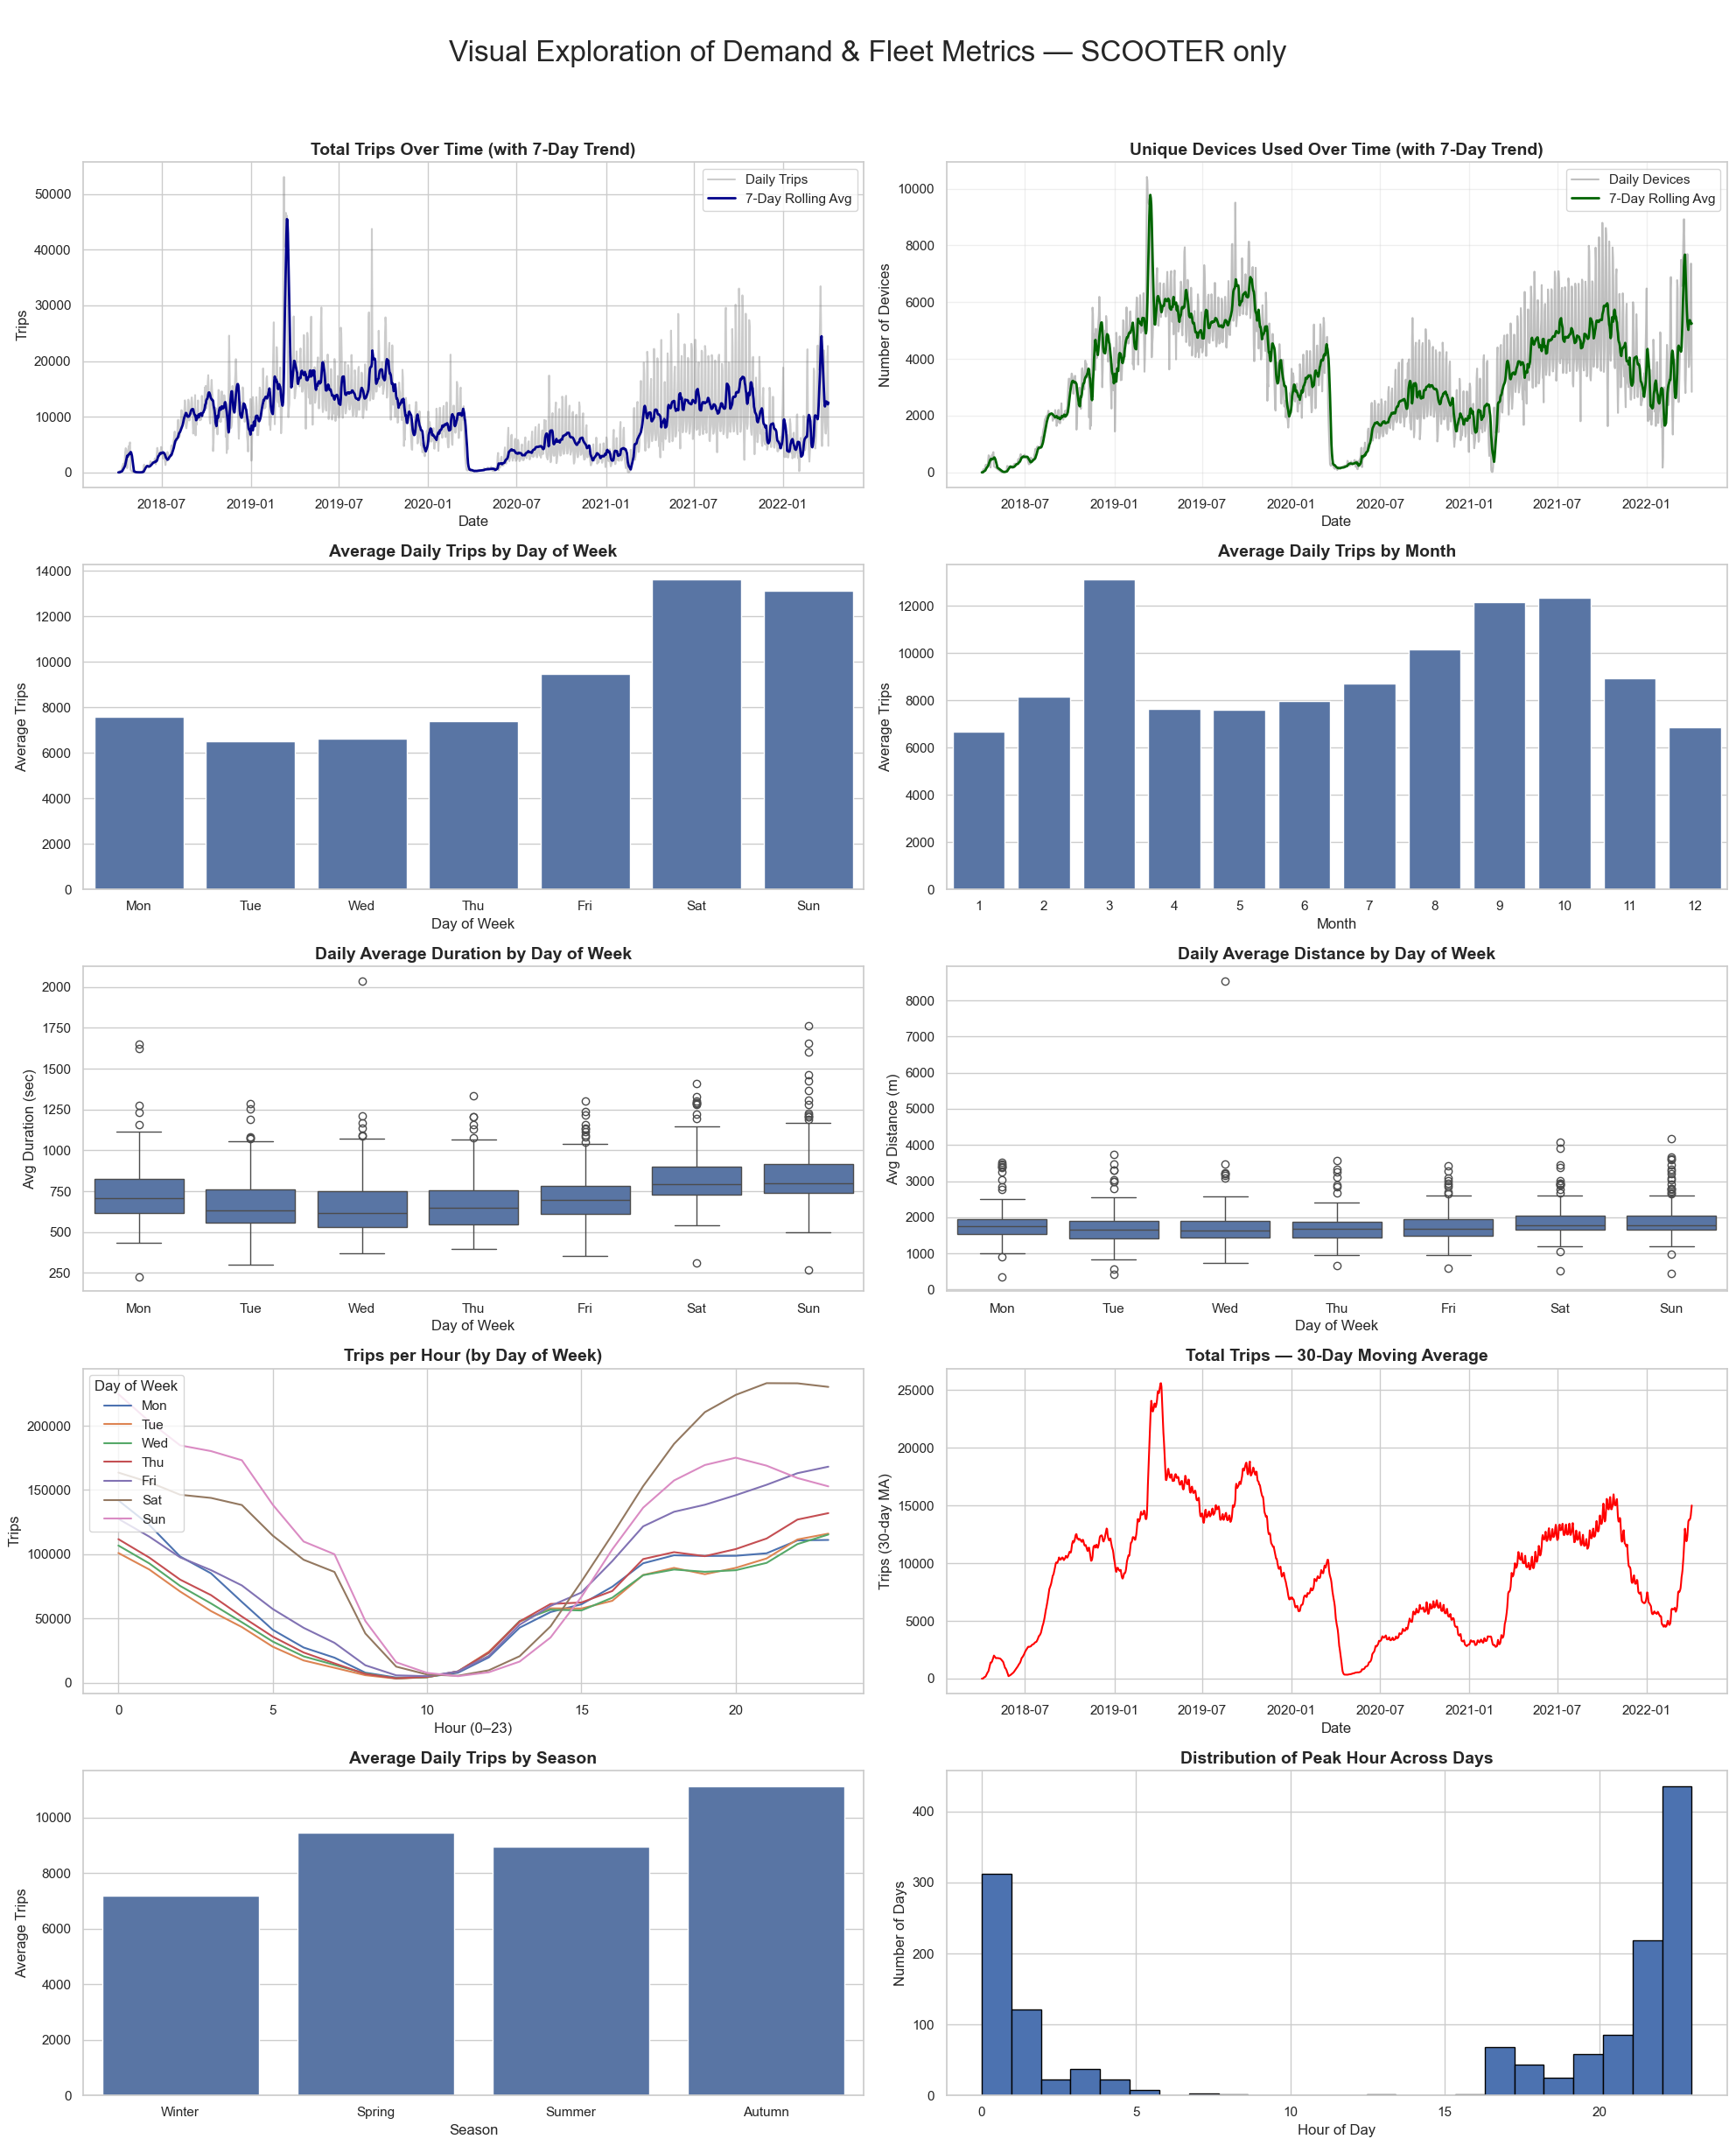

In [7]:
# Ensure Date is datetime
daily_data['Date'] = pd.to_datetime(daily_data['Date'])

# Pretty labels for day-of-week / season
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
season_map = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Autumn'}

# Convenience columns for plotting
daily_data = daily_data.copy()
daily_data['DayOfWeek_Name'] = daily_data['DayOfWeek'].map(day_map)
daily_data['Season_Name']    = daily_data['Season'].map(season_map)

# Title suffix to show the active vehicle type
title_suffix = f" — {VEHICLE_TYPE.upper()} only"

sns.set(style="whitegrid")

# Create subplot grid
fig, axes = plt.subplots(5, 2, figsize=(20, 25))
fig.suptitle("\nVisual Exploration of Demand & Fleet Metrics" + title_suffix,
             fontsize=24, y=1.01)

axes_flat = axes.flatten()

# ---------------------- ΚΑΤΗΓΟΡΙΑ 1: ΖΗΤΗΣΗ & ΠΡΟΣΦΟΡΑ ΣΤΟ ΧΡΟΝΟ ----------------------
# Ερώτηση 1: Υπάρχουν μεσοπρόθεσμες τάσεις ή διακυμάνσεις στη ζήτηση;
sns.lineplot(data=daily_data, x="Date", y="TotalTrips", ax=axes_flat[0], label='Daily Trips', alpha=0.4, color='gray')
sns.lineplot(data=daily_data, x="Date", y="TotalTrips_Roll7", ax=axes_flat[0], label='7-Day Rolling Avg', linewidth=2, color='darkblue')
axes_flat[0].set_title("Total Trips Over Time (with 7-Day Trend)", fontsize=14, fontweight='bold')
axes_flat[0].set_xlabel("Date"); axes_flat[0].set_ylabel("Trips"); axes_flat[0].legend()

# Ερώτηση 2: Ακολουθεί η προσφορά (συσκευές) τη ζήτηση μέσα στο χρόνο;
sns.lineplot(data=daily_data, x="Date", y="TotalUniqueDevices", ax=axes_flat[1], label='Daily Devices', color='gray', alpha=0.5)
sns.lineplot(data=daily_data, x="Date", y="Devices_Roll7", ax=axes_flat[1], label='7-Day Rolling Avg', color='darkgreen', linewidth=2)
axes_flat[1].set_title("Unique Devices Used Over Time (with 7-Day Trend)", fontsize=14, fontweight='bold')
axes_flat[1].set_xlabel("Date"); axes_flat[1].set_ylabel("Number of Devices")
axes_flat[1].legend(); axes_flat[1].grid(True, alpha=0.3)

# ---------------------- ΚΑΤΗΓΟΡΙΑ 2: ΕΠΟΧΙΚΟΤΗΤΑ ----------------------
# Ερώτηση 3: Ποιες ημέρες της εβδομάδας έχουν τη μεγαλύτερη μέση ζήτηση;
dow_avg = (daily_data.groupby("DayOfWeek", as_index=False)["TotalTrips"].mean()
           .assign(DayOfWeek_Name=lambda x: x['DayOfWeek'].map(day_map))
           .sort_values('DayOfWeek'))
sns.barplot(data=dow_avg, x="DayOfWeek_Name", y="TotalTrips", ax=axes_flat[2])
axes_flat[2].set_title("Average Daily Trips by Day of Week", fontsize=14, fontweight='bold')
axes_flat[2].set_xlabel("Day of Week"); axes_flat[2].set_ylabel("Average Trips")

# Ερώτηση 4: Ποιοι μήνες παρουσιάζουν την υψηλότερη ζήτηση;
month_avg = daily_data.groupby("Month", as_index=False)["TotalTrips"].mean()
sns.barplot(data=month_avg, x="Month", y="TotalTrips", ax=axes_flat[3])
axes_flat[3].set_title("Average Daily Trips by Month", fontsize=14, fontweight='bold')
axes_flat[3].set_xlabel("Month"); axes_flat[3].set_ylabel("Average Trips")

# ---------------------- ΚΑΤΗΓΟΡΙΑ 3: ΧΑΡΑΚΤΗΡΙΣΤΙΚΑ ΤΑΞΙΔΙΩΝ ----------------------
# Ερώτηση 5: Διαφέρουν οι μέσες διάρκειες ταξιδιών ανά ημέρα της εβδομάδας;
sns.boxplot(data=daily_data, x="DayOfWeek_Name", y="AvgDuration", ax=axes_flat[4], order=[day_map[d] for d in range(7)])
axes_flat[4].set_title("Daily Average Duration by Day of Week", fontsize=14, fontweight='bold')
axes_flat[4].set_xlabel("Day of Week"); axes_flat[4].set_ylabel("Avg Duration (sec)")

# Ερώτηση 6: Υπάρχουν διαφορές στις αποστάσεις ανά ημέρα της εβδομάδας;
sns.boxplot(data=daily_data, x="DayOfWeek_Name", y="AvgDistance", ax=axes_flat[5], order=[day_map[d] for d in range(7)])
axes_flat[5].set_title("Daily Average Distance by Day of Week", fontsize=14, fontweight='bold')
axes_flat[5].set_xlabel("Day of Week"); axes_flat[5].set_ylabel("Avg Distance (m)")

# ---------------------- ΚΑΤΗΓΟΡΙΑ 4: ΩΡΙΑΙΑ & ΜΑΚΡΟΧΡΟΝΙΕΣ ΤΑΣΕΙΣ ----------------------
# Ερώτηση 7: Πώς μεταβάλλεται το ωριαίο προφίλ χρήσης ανά ημέρα της εβδομάδας;
hour_day_df = df.groupby(['Hour', 'DayOfWeek'])['ID'].count().reset_index()
pivot_hour_day = hour_day_df.pivot(index='Hour', columns='DayOfWeek', values='ID')
pivot_hour_day.columns = [day_map[i] for i in sorted(pivot_hour_day.columns)]
pivot_hour_day.plot(ax=axes_flat[6], legend=False)
axes_flat[6].legend(title='Day of Week', labels=pivot_hour_day.columns, loc='upper left')
axes_flat[6].set_title("Trips per Hour (by Day of Week)", fontsize=14, fontweight='bold')
axes_flat[6].set_xlabel("Hour (0–23)"); axes_flat[6].set_ylabel("Trips")

# Ερώτηση 8: Υπάρχουν μακροχρόνιες μεταβολές στη συνολική ζήτηση;
sns.lineplot(data=daily_data, x="Date", y="TotalTrips_Roll30", ax=axes_flat[7], color='red')
axes_flat[7].set_title("Total Trips — 30-Day Moving Average", fontsize=14, fontweight='bold')
axes_flat[7].set_xlabel("Date"); axes_flat[7].set_ylabel("Trips (30-day MA)")
axes_flat[7].grid(True)

# ---------------------- ΚΑΤΗΓΟΡΙΑ 5: ΕΠΟΧΕΣ & ΩΡΕΣ ΚΟΡΥΦΩΣΗΣ ----------------------
# Ερώτηση 9: Ποια εποχή του έτους έχει τη μεγαλύτερη μέση ζήτηση;
season_avg = daily_data.groupby("Season_Name", as_index=False)["TotalTrips"].mean()
sns.barplot(data=season_avg, x="Season_Name", y="TotalTrips", ax=axes_flat[8], order=['Winter', 'Spring', 'Summer', 'Autumn'])
axes_flat[8].set_title("Average Daily Trips by Season", fontsize=14, fontweight='bold')
axes_flat[8].set_xlabel("Season"); axes_flat[8].set_ylabel("Average Trips")

# Ερώτηση 10: Ποιες ώρες της ημέρας παρατηρείται κορύφωση στη ζήτηση;
axes_flat[9].hist(daily_data['PeakHour'].fillna(0), bins=24, edgecolor='black')
axes_flat[9].set_title("Distribution of Peak Hour Across Days", fontsize=14, fontweight='bold')
axes_flat[9].set_xlabel("Hour of Day"); axes_flat[9].set_ylabel("Number of Days")

plt.tight_layout(rect=[0, 0.03, 1, 0.99])
plt.show()

# 7. Building & Training the LSTM/GRU Model
## 7.1. Final Feature Preparation and Data Partitioning
### 7.1.1. Feature Engineering and Dataset Splitting

In [8]:
try:
    daily_data = pd.read_csv('data/processed/final_daily_micromobility_data.csv', parse_dates=['Date'])
    aggregated_daily_df = daily_data.copy()
    print("✅ Aggregated data loaded for modeling.")
except FileNotFoundError:
    raise FileNotFoundError("data/processed/final_daily_micromobility_data.csv not found.")

# 2) Sort & date sanity checks
daily_data = daily_data.sort_values('Date').reset_index(drop=True)
assert daily_data['Date'].is_monotonic_increasing, "Dates are not monotonic."
assert daily_data['Date'].duplicated().sum() == 0, "Found duplicated dates."

# 3) Τελική λίστα features
INPUT_FEATURES = [
    # ===== Calendar / Seasonality =====
    'DayOfWeek_sin',
    'DayOfWeek_cos',
    'Month_sin',
    'Month_cos',
    'DayType',          # weekday / weekend

    # ===== Demand (clean & non-redundant) =====
    'TotalTrips_Lag7',  # weekly seasonality anchor
    'TotalTrips_EMA7',  # smooth recent trend
    'TotalTrips_Std7',  # volatility (uncertainty)

    # ===== Demand dynamics =====
    'Momentum7',        # week-over-week change

    # ===== Supply proxy (ONLY one) =====
    'Devices_Lag1',

    # ===== Trip characteristics (weekly, not daily) =====
    'MedianDistance_Lag7',
    'MedianDuration_Lag7',
]

TARGET = 'TotalTrips'

print(f"📊 Selected Features: {len(INPUT_FEATURES)}")

# 4) Extract features & target
X = daily_data[INPUT_FEATURES].to_numpy(dtype=np.float32)
Y = np.log1p(daily_data[TARGET].to_numpy(dtype=np.float32)).reshape(-1, 1)

# 5) Remove warm-up period (first 30 days with unstable lagged features)
WARMUP_DAYS = 30
X = X[WARMUP_DAYS:]
Y = Y[WARMUP_DAYS:]
daily_data = daily_data.iloc[WARMUP_DAYS:].reset_index(drop=True)

print(f"✅ After warm-up removal: {len(X)} days remaining")

# 6) Time-series split: Train (80%) | Test (20%) — contiguous, preserves chronology
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
Y_train, Y_test = Y[:split_point], Y[split_point:]

print(f"\n📊 Data Split:")
print(f"   Total: {len(X)} days")
print(f"   Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Test:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

✅ Aggregated data loaded for modeling.
📊 Selected Features: 12
✅ After warm-up removal: 1433 days remaining

📊 Data Split:
   Total: 1433 days
   Train: 1146 (80.0%)
   Test:  287 (20.0%)


### 7.1.2. Feature Correlation Matrix


📊 FEATURE CORRELATION ANALYSIS (Train only)
✅ No highly correlated feature pairs found (|r| > 0.9).


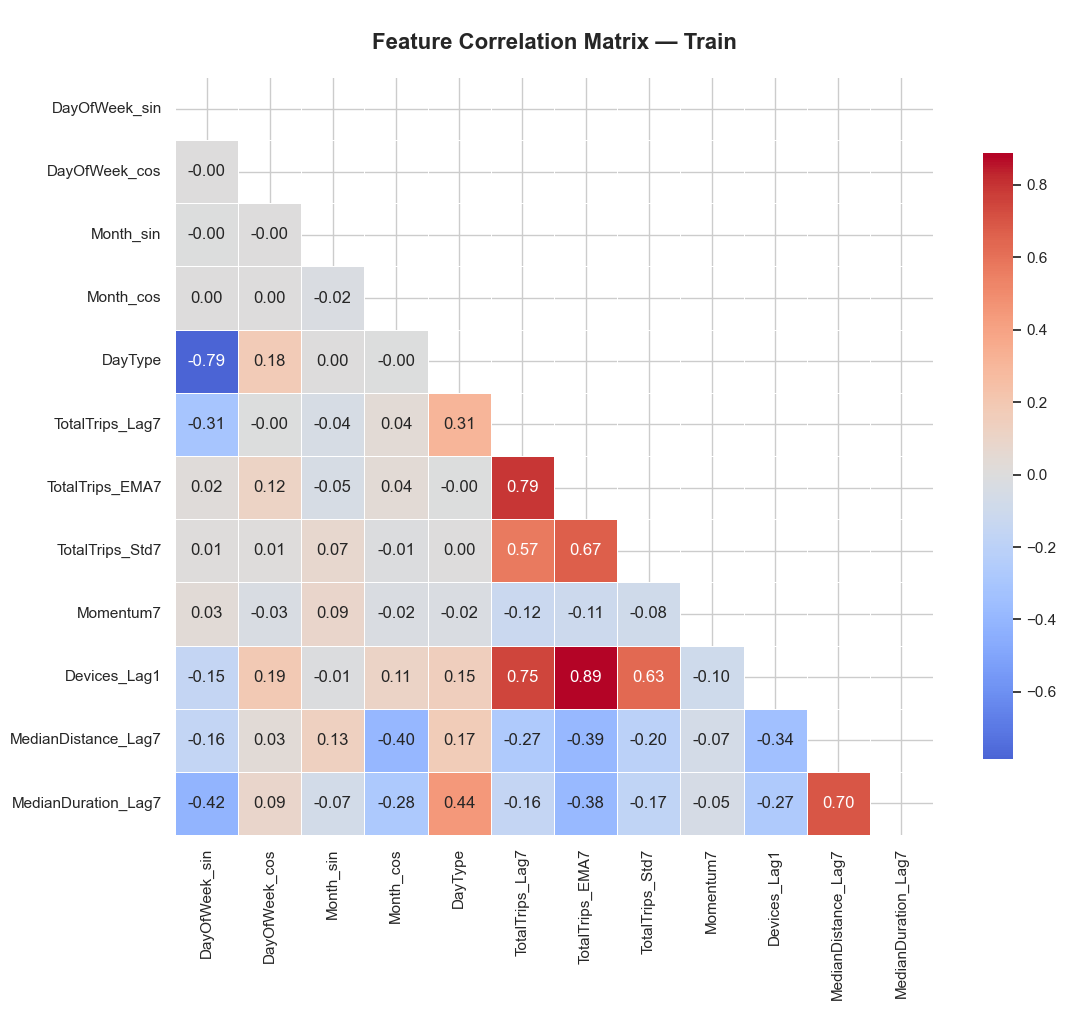

In [9]:
print("\n" + "="*70)
print("📊 FEATURE CORRELATION ANALYSIS (Train only)")
print("="*70)

# The correlation matrix shows the linear relationships (Pearson correlation) between each pair of features.
corr_df = pd.DataFrame(X_train, columns=INPUT_FEATURES)
corr_matrix = corr_df.corr()

threshold = 0.90
high_corr_pairs = []
cols = corr_matrix.columns.tolist()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        r = corr_matrix.iloc[i, j]
        if np.isfinite(r) and abs(r) > threshold:
            high_corr_pairs.append((cols[i], cols[j], float(r)))

if high_corr_pairs:
    print(f"\n⚠️ Highly correlated pairs (|r| > {threshold}):")
    for f1, f2, r in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"   {f1:22s} ↔ {f2:22s} : r = {r:6.3f}")
else:
    print(f"✅ No highly correlated feature pairs found (|r| > {threshold}).")

# Correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("\nFeature Correlation Matrix — Train", 
          fontsize=16, pad=20, fontweight='bold')
plt.tight_layout()
plt.show()

### 7.1.3. Multicollinearity Assessment with Variance Inflation Factor (VIF)


📊 MULTICOLLINEARITY ANALYSIS

⚠️  Variance Inflation Factor (VIF) Analysis:
   Rule: VIF > 10 indicates moderate multicollinearity
   Rule: VIF > 100 indicates severe multicollinearity
----------------------------------------------------------------------
            Feature       VIF
MedianDuration_Lag7 42.674263
MedianDistance_Lag7 40.630768
    TotalTrips_EMA7 27.748135
       Devices_Lag1 21.497234
    TotalTrips_Lag7 10.791608
    TotalTrips_Std7  5.342418
            DayType  4.475504
      DayOfWeek_sin  2.948807
      DayOfWeek_cos  1.227210
          Month_sin  1.129837
          Month_cos  1.107126
          Momentum7  1.031225

⚠️  Moderate multicollinearity detected:
   - MedianDuration_Lag7       (VIF: 42.7)
   - MedianDistance_Lag7       (VIF: 40.6)
   - TotalTrips_EMA7           (VIF: 27.7)
   - Devices_Lag1              (VIF: 21.5)
   - TotalTrips_Lag7           (VIF: 10.8)

   Note: VIF 10-50 is acceptable for deep learning models with regularization.


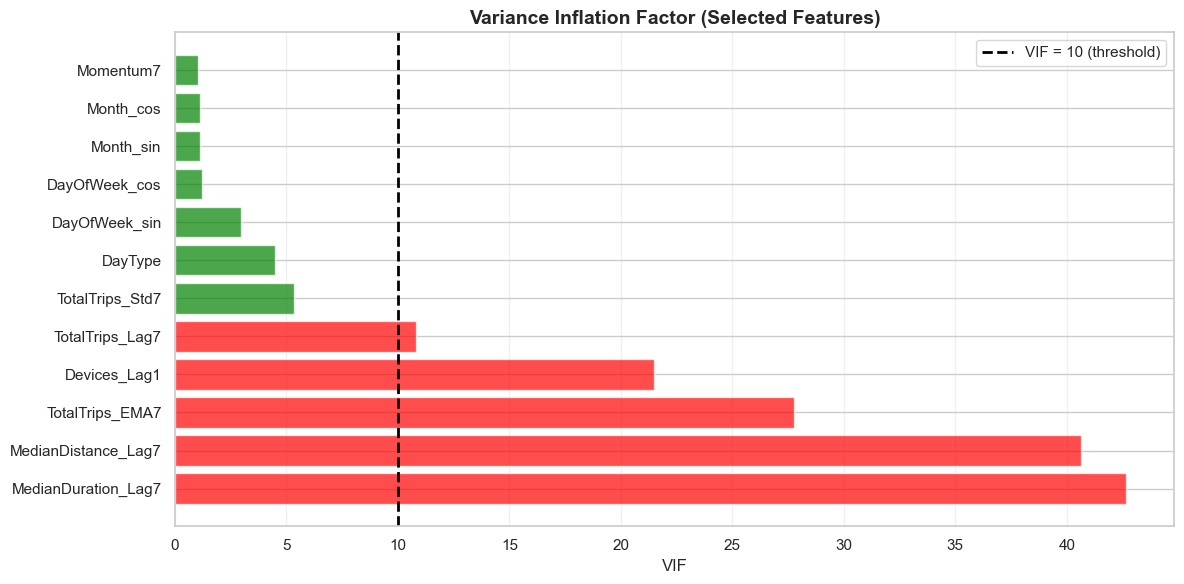

In [10]:
print("\n" + "="*70)
print("📊 MULTICOLLINEARITY ANALYSIS")
print("="*70)

# Ο VIF μετράει πόσο αυξάνεται η διακύμανση (variance) των εκτιμήσεων ενός feature εξαιτίας της γραμμικής σχέσης του με τα υπόλοιπα features.

def calculate_vif(df):
    """Calculate VIF for each feature."""
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) 
                       for i in range(len(df.columns))]
    return vif_data.sort_values('VIF', ascending=False)

# Calculate VIF on selected features
vif_df = calculate_vif(corr_df)

print("\n⚠️  Variance Inflation Factor (VIF) Analysis:")
print("   Rule: VIF > 10 indicates moderate multicollinearity")
print("   Rule: VIF > 100 indicates severe multicollinearity")
print("-" * 70)
print(vif_df.to_string(index=False))

high_vif = vif_df[vif_df['VIF'] > 10]['Feature'].tolist()
severe_vif = vif_df[vif_df['VIF'] > 100]['Feature'].tolist()

if len(high_vif) > 0:
    print(f"\n⚠️  Moderate multicollinearity detected:")
    for feat in high_vif:
        vif_val = vif_df[vif_df['Feature'] == feat]['VIF'].values[0]
        print(f"   - {feat:25s} (VIF: {vif_val:.1f})")
    print("\n   Note: VIF 10-50 is acceptable for deep learning models with regularization.")
else:
    print("✅ All features have VIF < 10 (excellent!)")

# VIF visualization
plt.figure(figsize=(12, 6))
colors = ['red' if v > 10 else 'green' for v in vif_df['VIF']]
plt.barh(vif_df['Feature'], vif_df['VIF'], color=colors, alpha=0.7)
plt.axvline(x=10, color='black', linestyle='--', linewidth=2, 
            label='VIF = 10 (threshold)')
plt.xlabel('VIF', fontsize=12)
plt.title('Variance Inflation Factor (Selected Features)', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 7.2. Scaling and Sequence Generation

In [11]:
# Helper: Identity Scaler for log-space target
class IdentityScaler:
    """Pass-through scaler for target (already in log1p space)."""
    def fit(self, X): 
        return self
    def transform(self, X): 
        return np.asarray(X)
    def inverse_transform(self, X): 
        return np.asarray(X)
    def fit_transform(self, X): 
        return self.fit(X).transform(X)

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler  = IdentityScaler()  # Keep Y in log-space without additional scaling

# Fit/Transform on TRAIN ONLY (no leakage)
X_train_scaled = feature_scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled  = feature_scaler.transform(X_test).astype(np.float32)

Y_train_scaled = target_scaler.fit_transform(Y_train).astype(np.float32)
Y_test_scaled  = target_scaler.transform(Y_test).astype(np.float32)

# Safety checks
for name, arr in [
    ("X_train_scaled", X_train_scaled), ("Y_train_scaled", Y_train_scaled),
    ("X_test_scaled",  X_test_scaled),  ("Y_test_scaled",  Y_test_scaled),
]:
    assert np.isfinite(arr).all(), f"❌ Found non-finite values in {name}!"
    assert not np.isnan(arr).any(), f"❌ NaN detected in {name}!"

print(f"✅ Feature scaling completed (StandardScaler on X)")
print(f"✅ Target kept in log1p space (IdentityScaler on Y)")
print(f"   Train X: {X_train_scaled.shape} | Train Y: {Y_train_scaled.shape}")
print(f"   Test  X: {X_test_scaled.shape}  | Test  Y: {Y_test_scaled.shape}")

# Sequence generator
def create_sequences(X, Y, sequence_length):
    """
    Create time windows for LSTM/GRU input.
    
    Args:
        X: (N, features) numpy array
        Y: (N, 1) numpy array
        sequence_length: int, lookback window
    
    Returns:
        X_seq: (N-seq_len, seq_len, features) tensor
        Y_seq: (N-seq_len, 1) tensor
    """
    X_seq, Y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])  # [i:i+seq_len] window
        Y_seq.append(Y[i + sequence_length])    # target at i+seq_len
    X_seq = np.asarray(X_seq, dtype=np.float32)
    Y_seq = np.asarray(Y_seq, dtype=np.float32)
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(Y_seq, dtype=torch.float32)

# Configuration
SEQUENCE_LENGTH = 70

# Train sequences (PURE train only)
X_train_seq, Y_train_seq = create_sequences(X_train_scaled, Y_train_scaled, SEQUENCE_LENGTH)

# Test sequences WITH CONTEXT (last SEQ_LEN train days as history)
X_test_ctx = np.concatenate([X_train_scaled[-SEQUENCE_LENGTH:], X_test_scaled], axis=0)
Y_test_ctx = np.concatenate([Y_train_scaled[-SEQUENCE_LENGTH:], Y_test_scaled], axis=0)
X_test_seq, Y_test_seq = create_sequences(X_test_ctx, Y_test_ctx, SEQUENCE_LENGTH)

print(f"\n✅ Sequence Generation Complete")
print(f"   Sequence Length: {SEQUENCE_LENGTH} days")
print(f"   Train sequences: {X_train_seq.shape} → {Y_train_seq.shape}")
print(f"   Test sequences:  {X_test_seq.shape}  → {Y_test_seq.shape}")

# Save artifacts (for inference)
os.makedirs("models", exist_ok=True)
with open("models/feature_scaler.pkl", "wb") as f:
    pickle.dump(feature_scaler, f)
with open("models/target_scaler.pkl", "wb") as f:
    pickle.dump(target_scaler, f)  # IdentityScaler (log-space)
with open("models/input_features.json", "w") as f:
    json.dump(INPUT_FEATURES, f)

print("\n💾 Saved artifacts:")
print("   - models/feature_scaler.pkl")
print("   - models/target_scaler.pkl (IdentityScaler for log-space)")
print("   - models/input_features.json")

# Time-based Validation Split (NO leakage)
full_train_seq_ds = TensorDataset(X_train_seq, Y_train_seq)

val_frac = 0.15
n_total = len(full_train_seq_ds)
n_val   = int(n_total * val_frac)
n_train = n_total - n_val

train_dataset = Subset(full_train_seq_ds, range(0, n_train))
val_dataset   = Subset(full_train_seq_ds, range(n_train, n_total))

print(f"\n⏳ Time-based Validation Split (from Train sequences):")
print(f"   Train subset: {len(train_dataset)} sequences ({len(train_dataset)/n_total*100:.1f}%)")
print(f"   Val subset:   {len(val_dataset)} sequences ({len(val_dataset)/n_total*100:.1f}%)")

✅ Feature scaling completed (StandardScaler on X)
✅ Target kept in log1p space (IdentityScaler on Y)
   Train X: (1146, 12) | Train Y: (1146, 1)
   Test  X: (287, 12)  | Test  Y: (287, 1)

✅ Sequence Generation Complete
   Sequence Length: 70 days
   Train sequences: torch.Size([1076, 70, 12]) → torch.Size([1076, 1])
   Test sequences:  torch.Size([287, 70, 12])  → torch.Size([287, 1])

💾 Saved artifacts:
   - models/feature_scaler.pkl
   - models/target_scaler.pkl (IdentityScaler for log-space)
   - models/input_features.json

⏳ Time-based Validation Split (from Train sequences):
   Train subset: 915 sequences (85.0%)
   Val subset:   161 sequences (15.0%)


## 7.3. Model Definition and Setup
### 7.3.1. LSTM

In [12]:
print("\n" + "="*70)
print("🏗️  LSTM MODEL ARCHITECTURE")
print("="*70)

# Lag features for autoregressive component
LAG_FEATURE_NAMES = ['TotalTrips_Lag1', 'TotalTrips_Lag7']
LAG_IDXS = [INPUT_FEATURES.index(n) for n in LAG_FEATURE_NAMES if n in INPUT_FEATURES]

print(f"Autoregressive component uses: {LAG_FEATURE_NAMES}")
print(f"Lag feature indices: {LAG_IDXS}")

class TwoWheelerLSTM(nn.Module):
    """
    LSTM model for micromobility demand forecasting.
    
    Architecture:
    - Multi-layer LSTM for temporal pattern learning
    - Layer normalization for training stability
    - Dropout for regularization
    - Autoregressive head for residual connections (baseline from recent lags)
    
    The AR component acts as a "safety net": if LSTM is uncertain, 
    it falls back to a linear combination of recent lags (Lag1, Lag7).
    """
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0.0
        )
        
        # Regularization
        self.norm = nn.LayerNorm(hidden_size)
        self.drop = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Autoregressive component (residual connection from recent lags)
        self.use_ar = len(LAG_IDXS) > 0
        if self.use_ar:
            self.ar_head = nn.Linear(len(LAG_IDXS), output_size, bias=False)
        
        # Xavier initialization
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using Xavier uniform."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: (batch, seq_len, features) - input sequences
        
        Returns:
            y: (batch, 1) - demand predictions
        """
        batch_size = x.size(0)
        
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        
        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Take last timestep output
        out_last = out[:, -1, :]
        
        # Normalization and dropout
        out_last = self.norm(out_last)
        out_last = self.drop(out_last)
        
        # LSTM prediction
        y = self.fc(out_last)
        
        # Add autoregressive component (residual connection)
        if self.use_ar:
            last_step = x[:, -1, :]            # Last input timestep
            ar_in = last_step[:, LAG_IDXS]    # Extract lag features
            y = y + self.ar_head(ar_in)       # y = LSTM_pred + α·Lag1 + β·Lag7
        
        return y

# Hyperparameters
INPUT_SIZE = X_train_seq.shape[2]
HIDDEN_SIZE = 128
NUM_LAYERS = 2
OUTPUT_SIZE = 1
DROPOUT_RATE = 0.15
LEARNING_RATE = 0.0012
NUM_EPOCHS = 150
BATCH_SIZE = 32

# Initialize LSTM Model
model = TwoWheelerLSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_RATE)

class WeightedSmoothL1Loss(nn.Module):
    """
    Weighted Huber loss for log1p targets.
    Loss is computed in log-space, but weights are based on trips scale.
    """
    def __init__(self, beta=1.0, q=0.80, w_high=2.0, w_low=1.0):
        super().__init__()
        self.beta = beta
        self.q = q
        self.w_high = w_high
        self.w_low = w_low
        self._q_threshold = None

    def set_quantile_threshold_from_train(self, y_train_log):
        # y_train_log: log1p targets (train only!)
        if isinstance(y_train_log, torch.Tensor):
            y = y_train_log.detach().cpu().numpy().ravel()
        else:
            y = y_train_log.reshape(-1)

        trips = torch.tensor(np.expm1(y), dtype=torch.float32)
        self._q_threshold = float(torch.quantile(trips, self.q))

    def forward(self, pred_log, target_log):
        if self._q_threshold is None:
            raise RuntimeError("Quantile threshold not initialized")

        trips_target = torch.expm1(target_log)

        weights = torch.where(
            trips_target > self._q_threshold,
            torch.tensor(self.w_high, device=pred_log.device),
            torch.tensor(self.w_low, device=pred_log.device)
        )

        loss = F.smooth_l1_loss(
            pred_log,
            target_log,
            beta=self.beta,
            reduction='none'
        )

        return (loss * weights).mean()

# Loss function (Weighted Huber in log-space)
criterion = WeightedSmoothL1Loss(
    beta=1.0,
    q=0.80,        # top 20% = high demand
    w_high=2.0,    # 2x penalty for high demand errors
    w_low=1.0
)

# Initialize weights using TRAIN targets only (NO leakage)
criterion.set_quantile_threshold_from_train(torch.tensor(Y_train_scaled))

print(
    f"✅ Weighted loss enabled | High-demand threshold "
    f"(q={criterion.q:.2f}) = {criterion._q_threshold:,.0f} trips"
)

# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-6
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=20,
    min_lr=1e-6
)

# Model summary
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n   Architecture: LSTM")
print(f"   Layers: {NUM_LAYERS} | Hidden Size: {HIDDEN_SIZE}")
print(f"   Dropout: {DROPOUT_RATE} | Weight Decay: 1e-6")
print(f"   Input Features: {INPUT_SIZE}")
print(f"   Sequence Length: {SEQUENCE_LENGTH} days")
print(f"   Total Parameters: {param_count:,}")
print(f"   Optimizer: AdamW (LR: {LEARNING_RATE})")
print(f"   Loss Function: SmoothL1Loss (Huber, β=1.0)")
print(f"   AR Component: Enabled (uses {len(LAG_IDXS)} lag features)")
print("="*70)


🏗️  LSTM MODEL ARCHITECTURE
Autoregressive component uses: ['TotalTrips_Lag1', 'TotalTrips_Lag7']
Lag feature indices: [5]
✅ Weighted loss enabled | High-demand threshold (q=0.80) = 14,345 trips

   Architecture: LSTM
   Layers: 2 | Hidden Size: 128
   Dropout: 0.15 | Weight Decay: 1e-6
   Input Features: 12
   Sequence Length: 70 days
   Total Parameters: 205,186
   Optimizer: AdamW (LR: 0.0012)
   Loss Function: SmoothL1Loss (Huber, β=1.0)
   AR Component: Enabled (uses 1 lag features)


### 7.3.2. GRU

In [13]:
print("\n" + "="*70)
print("🔄 GRU MODEL ARCHITECTURE")
print("="*70)

class TwoWheelerGRU(nn.Module):
    """
    GRU model for micromobility demand forecasting.
    Same architecture as LSTM for fair comparison.
    
    GRU uses fewer parameters than LSTM (no cell state c),
    but maintains similar representational capacity.
    """
    
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # GRU layers
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0.0
        )
        
        # Regularization
        self.norm = nn.LayerNorm(hidden_size)
        self.drop = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
        # Autoregressive component
        self.use_ar = len(LAG_IDXS) > 0
        if self.use_ar:
            self.ar_head = nn.Linear(len(LAG_IDXS), output_size, bias=False)
        
        # Xavier initialization
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using Xavier uniform."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: (batch, seq_len, features)
        
        Returns:
            y: (batch, 1) predictions
        """
        batch_size = x.size(0)
        
        # Initialize hidden state (GRU has no cell state)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size)
        
        # GRU forward pass
        out, _ = self.gru(x, h0)
        
        # Take last timestep output
        out_last = out[:, -1, :]
        
        # Normalization and dropout
        out_last = self.norm(out_last)
        out_last = self.drop(out_last)
        
        # GRU prediction
        y = self.fc(out_last)
        
        # Add autoregressive component
        if self.use_ar:
            last_step = x[:, -1, :]
            ar_in = last_step[:, LAG_IDXS]
            y = y + self.ar_head(ar_in)
        
        return y

# Initialize GRU Model (same hyperparameters)
gru_model = TwoWheelerGRU(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT_RATE)

# Weighted Huber Loss (same as LSTM)
gru_criterion = WeightedSmoothL1Loss(
    beta=1.0,
    q=0.80,        # top 20% high demand
    w_high=2.0,    # 2x penalty for high-demand errors
    w_low=1.0
)

# Initialize threshold using TRAIN targets only (NO leakage)
gru_criterion.set_quantile_threshold_from_train(torch.tensor(Y_train_scaled))

print(
    f"✅ GRU Weighted loss enabled | High-demand threshold "
    f"(q={gru_criterion.q:.2f}) = {gru_criterion._q_threshold:,.0f} trips"
)

# Same optimizer & scheduler as LSTM
gru_optimizer = torch.optim.AdamW(
    gru_model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=1e-6
)

gru_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    gru_optimizer,
    mode='min',
    factor=0.5,
    patience=20,
    min_lr=1e-6
)

# Model Comparison
lstm_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
gru_params = sum(p.numel() for p in gru_model.parameters() if p.requires_grad)

print(f"\n📊 Architecture Comparison:")
print(f"   LSTM Parameters: {lstm_params:,}")
print(f"   GRU Parameters:  {gru_params:,}")
print(f"   Difference:      {lstm_params - gru_params:,} ({(1-gru_params/lstm_params)*100:.1f}% fewer in GRU)")
print(f"\n   Note: GRU has fewer parameters due to lack of cell state")
print(f"   Both models use {len(LAG_IDXS)} lag features in AR head")
print("="*70)


🔄 GRU MODEL ARCHITECTURE
✅ GRU Weighted loss enabled | High-demand threshold (q=0.80) = 14,345 trips

📊 Architecture Comparison:
   LSTM Parameters: 205,186
   GRU Parameters:  153,986
   Difference:      51,200 (25.0% fewer in GRU)

   Note: GRU has fewer parameters due to lack of cell state
   Both models use 1 lag features in AR head


### 7.3.3. DataLoaders

In [14]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Test loader for evaluation only
test_dataset = TensorDataset(X_test_seq, Y_test_seq)
test_loader  = DataLoader(test_dataset, batch_size=512, shuffle=False, drop_last=False)

print(f"📦 DataLoaders Created:")
print(f"   Train: {len(train_loader)} batches | {len(train_dataset)} samples")
print(f"   Val:   {len(val_loader)} batches | {len(val_dataset)} samples")
print(f"   Test:  {len(test_loader)} batches | {len(test_dataset)} samples")
print(f"   Batch Size: {BATCH_SIZE}")
print("="*70)

📦 DataLoaders Created:
   Train: 29 batches | 915 samples
   Val:   6 batches | 161 samples
   Test:  1 batches | 287 samples
   Batch Size: 32


## 7.4. Model Training

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler=None, num_epochs=150, max_grad_norm=1.0, 
                patience=25, print_every=10, model_name="Model"):
    """
    Train LSTM/GRU model with comprehensive monitoring.
    
    Features:
        Training & validation loss tracking
        Early stopping (patience-based)
        Gradient clipping (prevents exploding gradients)
        Learning rate scheduling (ReduceLROnPlateau)
        Best model checkpoint saving
        Training time tracking
    
    Args:
        model: PyTorch model (LSTM or GRU)
        train_loader: DataLoader for training set
        val_loader: DataLoader for validation set
        criterion: Loss function
        optimizer: Optimizer (AdamW)
        scheduler: LR scheduler (optional)
        num_epochs: Maximum number of epochs
        max_grad_norm: Gradient clipping threshold
        patience: Early stopping patience
        print_every: Print frequency (epochs)
        model_name: Name for logging
    
    Returns:
        model: Trained model (with best weights restored)
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
    """
    print("\n" + "="*70)
    print(f"🚀 STARTING {model_name.upper()} TRAINING")
    print("="*70)
    start_time = time.time()
    
    best_val = float('inf')
    best_state = None
    best_epoch = 0
    waited = 0
    train_losses, val_losses = [], []

    # Safety for empty loaders
    assert len(train_loader) > 0, "❌ train_loader is empty"
    assert len(val_loader) > 0, "❌ val_loader is empty"
    
    for epoch in tqdm(range(1, num_epochs + 1), desc=f"Training {model_name}"):

        # -------------------
        # Training Phase
        # -------------------
        model.train()
        running_train_loss = 0.0
        
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, Y_batch)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step()
            running_train_loss += loss.item()
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # -------------------
        # Validation Phase
        # -------------------
        model.eval()
        val_loss_total = 0.0
        
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                preds = model(X_batch)
                vloss = criterion(preds, Y_batch)
                val_loss_total += vloss.item()
        
        avg_val_loss = val_loss_total / len(val_loader)
        val_losses.append(avg_val_loss)

        # Guard for NaN/Inf losses
        if not np.isfinite(avg_train_loss) or not np.isfinite(avg_val_loss):
            print("❌ Non-finite loss detected. Stopping training.")
            break
        
        # -------------------
        # Learning Rate Scheduling
        # -------------------
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()

        # -------------------
        # Logging
        # -------------------
        if (epoch % print_every == 0) or (epoch == 1):
            lr = optimizer.param_groups[0]['lr']
            print(f"Epoch [{epoch:03d}/{num_epochs}] | "
                  f"Train: {avg_train_loss:.5f} | "
                  f"Val: {avg_val_loss:.5f} | "
                  f"LR: {lr:.6f}")

        # -------------------
        # Early Stopping & Checkpoint
        # -------------------
        min_delta = 1e-5

        if avg_val_loss < best_val - min_delta:
            best_val = avg_val_loss
            best_epoch = epoch
            waited = 0

            # Save Best Model State
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            waited += 1
            if waited >= patience:
                print(f"\n⏹️ Early stopping triggered at epoch {epoch}")
                print(f"    No improvement for {patience} epochs")
                print(f"    Best validation loss: {best_val:.5f} at epoch {best_epoch}")
                break
    
    # Restore Best Model
    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"\n✅ Restored best model from epoch {best_epoch}")
    else:
        print("\n⚠️ No best_state saved (training may have diverged early).")
    
    total_time = time.time() - start_time
    print("="*70)
    print(f"✅ Training completed in {total_time/60:.2f} min ({total_time:.1f}s)")
    print(f"🏆 Best Validation Loss: {best_val:.5f} (epoch {best_epoch})")
    print(f"📊 Total Epochs Run: {epoch}/{num_epochs}")
    print("="*70)
    
    return model, train_losses, val_losses

### 7.4.1. LSTM


🚀 STARTING LSTM TRAINING


Training LSTM:   1%|▍                                                                  | 1/150 [00:00<01:58,  1.26it/s]

Epoch [001/150] | Train: 2.08114 | Val: 1.55057 | LR: 0.001200


Training LSTM:   7%|████▍                                                             | 10/150 [00:07<01:38,  1.43it/s]

Epoch [010/150] | Train: 0.26794 | Val: 0.46777 | LR: 0.001200


Training LSTM:  13%|████████▊                                                         | 20/150 [00:14<01:32,  1.40it/s]

Epoch [020/150] | Train: 0.20162 | Val: 0.40444 | LR: 0.001200


Training LSTM:  20%|█████████████▏                                                    | 30/150 [00:21<01:26,  1.39it/s]

Epoch [030/150] | Train: 0.19933 | Val: 0.24013 | LR: 0.001200


Training LSTM:  27%|█████████████████▌                                                | 40/150 [00:28<01:18,  1.40it/s]

Epoch [040/150] | Train: 0.17565 | Val: 0.18595 | LR: 0.001200


Training LSTM:  33%|██████████████████████                                            | 50/150 [00:35<01:09,  1.43it/s]

Epoch [050/150] | Train: 0.24407 | Val: 0.20163 | LR: 0.001200


Training LSTM:  40%|██████████████████████████▍                                       | 60/150 [00:42<01:02,  1.43it/s]

Epoch [060/150] | Train: 0.14999 | Val: 0.28156 | LR: 0.001200


Training LSTM:  47%|██████████████████████████████▊                                   | 70/150 [00:49<00:58,  1.37it/s]

Epoch [070/150] | Train: 0.13508 | Val: 0.22054 | LR: 0.001200


Training LSTM:  53%|███████████████████████████████████▏                              | 80/150 [00:57<00:49,  1.41it/s]

Epoch [080/150] | Train: 0.13317 | Val: 0.26317 | LR: 0.000600


Training LSTM:  53%|███████████████████████████████████▏                              | 80/150 [00:57<00:50,  1.39it/s]


⏹️ Early stopping triggered at epoch 81
    No improvement for 25 epochs
    Best validation loss: 0.17537 at epoch 56

✅ Restored best model from epoch 56
✅ Training completed in 0.96 min (57.7s)
🏆 Best Validation Loss: 0.17537 (epoch 56)
📊 Total Epochs Run: 81/150

💾 LSTM checkpoint saved to 'models/lstm_demand_model.pth'


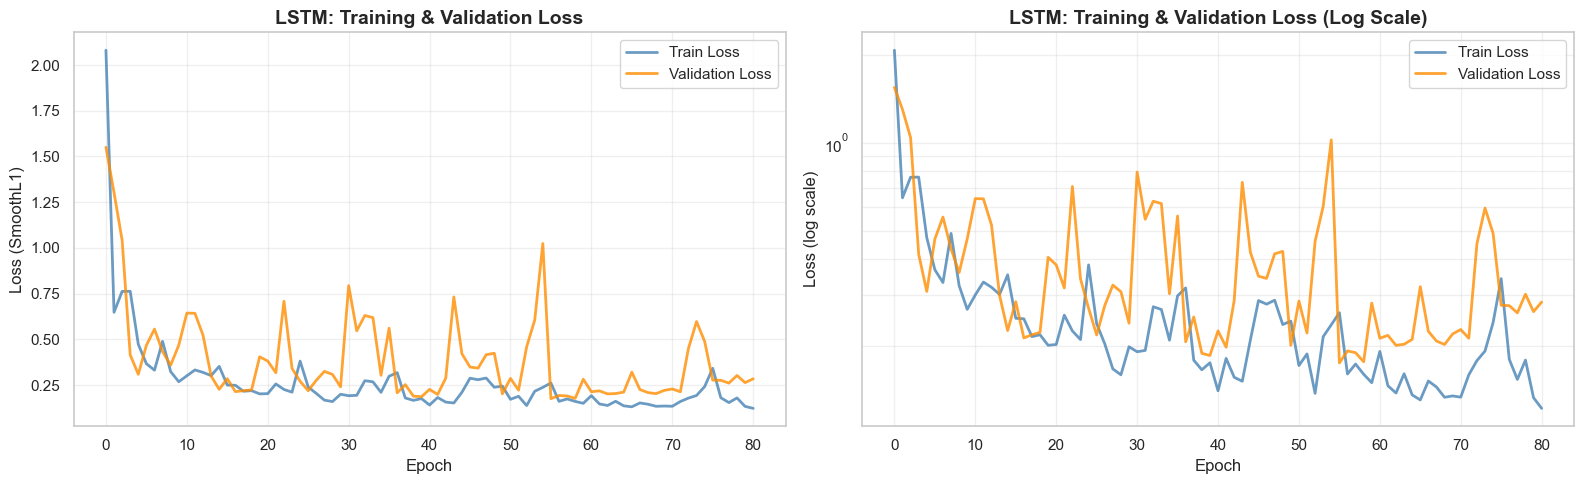


📊 LSTM Training Summary:
   Training time: 0.96 min
   Final train loss: 0.12245
   Final val loss: 0.28388
   Best val loss: 0.17537


In [16]:
lstm_t0 = time.time()
trained_lstm, lstm_train_losses, lstm_val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    max_grad_norm=1.0,
    patience=25,
    print_every=10,
    model_name="LSTM"
)
lstm_training_time = time.time() - lstm_t0

torch.save(trained_lstm.state_dict(), 'models/lstm_demand_model.pth')
print("\n💾 LSTM checkpoint saved to 'models/lstm_demand_model.pth'")

# Most safe best validation from the list (handle edge cases)
best_lstm_val = np.min(lstm_val_losses) if len(lstm_val_losses) > 0 else np.nan

# Plot LSTM training curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Linear scale
axes[0].plot(lstm_train_losses, label='Train Loss', linewidth=2, color='steelblue', alpha=0.8)
axes[0].plot(lstm_val_losses, label='Validation Loss', linewidth=2, color='darkorange', alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (SmoothL1)', fontsize=12)
axes[0].set_title('LSTM: Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].plot(lstm_train_losses, label='Train Loss', linewidth=2, color='steelblue', alpha=0.8)
axes[1].plot(lstm_val_losses, label='Validation Loss', linewidth=2, color='darkorange', alpha=0.8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss (log scale)', fontsize=12)
axes[1].set_yscale('log')
axes[1].set_title('LSTM: Training & Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

final_lstm_train = lstm_train_losses[-1] if len(lstm_train_losses) > 0 else np.nan
final_lstm_val   = lstm_val_losses[-1] if len(lstm_val_losses) > 0 else np.nan

print(f"\n📊 LSTM Training Summary:")
print(f"   Training time: {lstm_training_time/60:.2f} min")
print(f"   Final train loss: {final_lstm_train:.5f}")
print(f"   Final val loss: {final_lstm_val:.5f}")
print(f"   Best val loss: {best_lstm_val:.5f}")

### 7.4.2. GRU


🚀 STARTING GRU TRAINING


Training GRU:   1%|▍                                                                   | 1/150 [00:01<03:29,  1.41s/it]

Epoch [001/150] | Train: 3.19012 | Val: 3.63366 | LR: 0.001200


Training GRU:   7%|████▍                                                              | 10/150 [00:13<03:04,  1.32s/it]

Epoch [010/150] | Train: 0.39938 | Val: 0.67204 | LR: 0.001200


Training GRU:  13%|████████▉                                                          | 20/150 [00:26<02:50,  1.31s/it]

Epoch [020/150] | Train: 0.26576 | Val: 0.25901 | LR: 0.001200


Training GRU:  20%|█████████████▍                                                     | 30/150 [00:39<02:39,  1.33s/it]

Epoch [030/150] | Train: 0.18819 | Val: 0.31502 | LR: 0.001200


Training GRU:  27%|█████████████████▊                                                 | 40/150 [00:52<02:26,  1.33s/it]

Epoch [040/150] | Train: 0.23153 | Val: 0.29517 | LR: 0.001200


Training GRU:  33%|██████████████████████▎                                            | 50/150 [01:05<02:12,  1.32s/it]

Epoch [050/150] | Train: 0.29896 | Val: 0.19719 | LR: 0.001200


Training GRU:  40%|██████████████████████████▊                                        | 60/150 [01:19<01:57,  1.31s/it]

Epoch [060/150] | Train: 0.18782 | Val: 0.29469 | LR: 0.001200


Training GRU:  47%|███████████████████████████████▎                                   | 70/150 [01:32<01:46,  1.33s/it]

Epoch [070/150] | Train: 0.26765 | Val: 0.50391 | LR: 0.001200


Training GRU:  49%|█████████████████████████████████                                  | 74/150 [01:38<01:41,  1.34s/it]


⏹️ Early stopping triggered at epoch 75
    No improvement for 25 epochs
    Best validation loss: 0.19719 at epoch 50

✅ Restored best model from epoch 50
✅ Training completed in 1.65 min (98.9s)
🏆 Best Validation Loss: 0.19719 (epoch 50)
📊 Total Epochs Run: 75/150

💾 GRU checkpoint saved to 'models/gru_demand_model.pth'


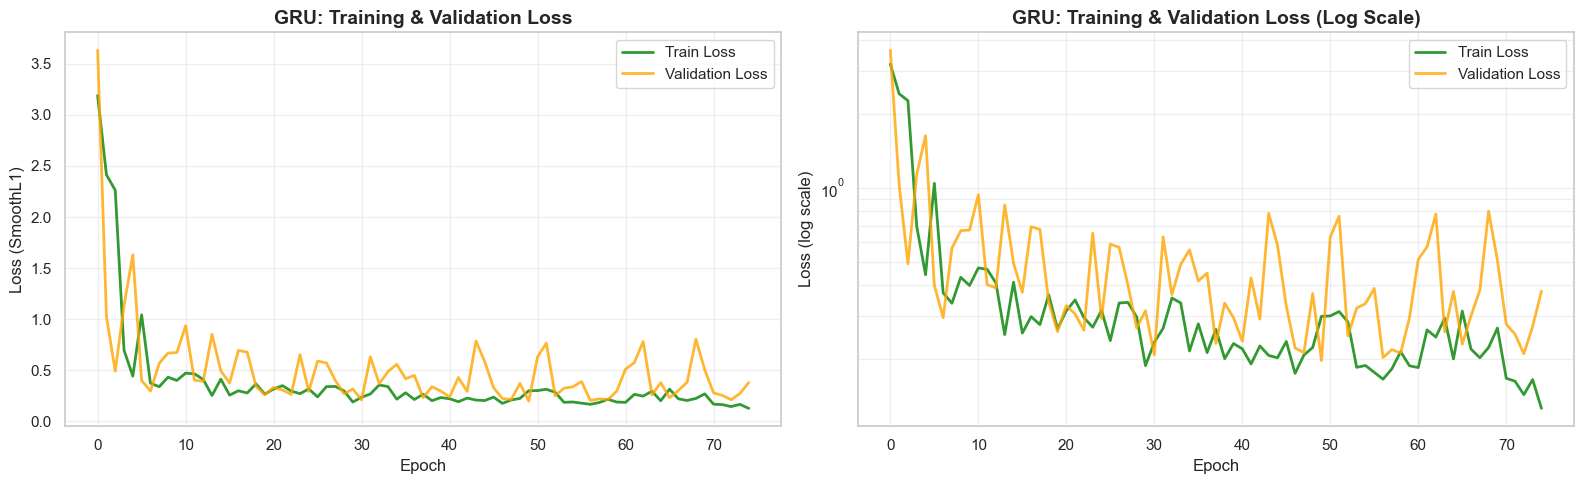


📊 GRU Training Summary:
   Training time: 1.65 min
   Final train loss: 0.12599
   Final val loss: 0.37831
   Best val loss: 0.19719


In [17]:
gru_t0 = time.time()
trained_gru, gru_train_losses, gru_val_losses = train_model(
    model=gru_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=gru_criterion,
    optimizer=gru_optimizer,
    scheduler=gru_scheduler,
    num_epochs=NUM_EPOCHS,
    max_grad_norm=1.0,
    patience=25,
    print_every=10,
    model_name="GRU"
)
gru_training_time = time.time() - gru_t0

torch.save(trained_gru.state_dict(), 'models/gru_demand_model.pth')
print("\n💾 GRU checkpoint saved to 'models/gru_demand_model.pth'")

# Safest best validation
best_gru_val = np.min(gru_val_losses) if len(gru_val_losses) > 0 else np.nan

# Plot GRU training curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Linear scale
axes[0].plot(gru_train_losses, label='Train Loss', linewidth=2, color='green', alpha=0.8)
axes[0].plot(gru_val_losses, label='Validation Loss', linewidth=2, color='orange', alpha=0.8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (SmoothL1)', fontsize=12)
axes[0].set_title('GRU: Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].plot(gru_train_losses, label='Train Loss', linewidth=2, color='green', alpha=0.8)
axes[1].plot(gru_val_losses, label='Validation Loss', linewidth=2, color='orange', alpha=0.8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss (log scale)', fontsize=12)
axes[1].set_yscale('log')
axes[1].set_title('GRU: Training & Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

final_gru_train = gru_train_losses[-1] if len(gru_train_losses) > 0 else np.nan
final_gru_val   = gru_val_losses[-1] if len(gru_val_losses) > 0 else np.nan

print(f"\n📊 GRU Training Summary:")
print(f"   Training time: {gru_training_time/60:.2f} min")
print(f"   Final train loss: {final_gru_train:.5f}")
print(f"   Final val loss: {final_gru_val:.5f}")
print(f"   Best val loss: {best_gru_val:.5f}")

## 7.5. Model Evaluation and Visualization
### 7.5.1. Metrics Functions

In [18]:
def masked_mape(y_true, y_pred, min_actual=10):
    y_true, y_pred = np.asarray(y_true).ravel(), np.asarray(y_pred).ravel()
    mask = y_true >= min_actual
    if mask.sum() == 0:
        return np.nan
    return float(np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100)

def regression_report(y_true, y_pred, min_actual=10):
    y_true, y_pred = np.asarray(y_true).ravel(), np.asarray(y_pred).ravel()
    mae = float(np.mean(np.abs(y_true - y_pred)))
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    smape = float(100 * np.mean(2 * np.abs(y_pred - y_true) /
                                (np.abs(y_true) + np.abs(y_pred) + 1e-6)))
    mape = masked_mape(y_true, y_pred, min_actual)
    return {"MAE": mae, "RMSE": rmse, "sMAPE%": smape, "MAPE%@>=10": mape}

def evaluate_model(model, loader, target_scaler, name="Test"):
    model.eval()
    preds_log, targs_log = [], []

    with torch.no_grad():
        for X_batch, Y_batch in loader:
            yhat = model(X_batch)
            preds_log.append(yhat.detach().cpu().numpy())
            targs_log.append(Y_batch.detach().cpu().numpy())

    preds_log = np.concatenate(preds_log, axis=0)
    targs_log = np.concatenate(targs_log, axis=0)

    # IdentityScaler → no change, αλλά το κρατάμε για συνέπεια
    preds_log = target_scaler.inverse_transform(preds_log).ravel()
    targs_log = target_scaler.inverse_transform(targs_log).ravel()

    # BACK TO TRIPS SCALE
    preds_trips = np.expm1(preds_log)
    targs_trips = np.expm1(targs_log)

    preds_trips = np.clip(preds_trips, 0, None)
    targs_trips = np.clip(targs_trips, 0, None)

    metrics = regression_report(targs_trips, preds_trips, min_actual=10)
    return targs_trips, preds_trips, metrics

### 7.5.2. Prepare Evaluation Loaders

In [19]:
print("\n" + "="*70)
print("📊 MODEL EVALUATION")
print("="*70)

eval_batch_size = 512

train_eval_dataset = TensorDataset(X_train_seq, Y_train_seq)
test_eval_dataset  = TensorDataset(X_test_seq,  Y_test_seq)

train_loader_eval = DataLoader(train_eval_dataset, batch_size=eval_batch_size, shuffle=False)
test_loader_eval  = DataLoader(test_eval_dataset,  batch_size=eval_batch_size, shuffle=False)

print(f"✅ Evaluation loaders created:")
print(f"   Train: {len(train_loader_eval)} batches ({len(train_eval_dataset)} samples)")
print(f"   Test:  {len(test_loader_eval)} batches ({len(test_eval_dataset)} samples)")


📊 MODEL EVALUATION
✅ Evaluation loaders created:
   Train: 3 batches (1076 samples)
   Test:  1 batches (287 samples)


### 7.5.3. Model Evaluation and Baseline Models

In [20]:
print("\n🔵 Evaluating LSTM...")
train_targets, train_preds, train_metrics = evaluate_model(trained_lstm, train_loader_eval, target_scaler, "Train")
test_targets,  test_preds,  test_metrics  = evaluate_model(trained_lstm, test_loader_eval,  target_scaler, "Test")

print(f"   Train samples: {len(train_targets)}")
print(f"   Test samples:  {len(test_targets)}")

print("\n🟢 Evaluating GRU...")
gru_train_targets, gru_train_preds, gru_train_metrics = evaluate_model(trained_gru, train_loader_eval, target_scaler, "Train")
gru_test_targets,  gru_test_preds,  gru_test_metrics  = evaluate_model(trained_gru, test_loader_eval,  target_scaler, "Test")

print(f"   Train samples: {len(gru_train_targets)}")
print(f"   Test samples:  {len(gru_test_targets)}")

# One-step-ahead Baseline Models
tt = test_targets.ravel()
train_tt = train_targets.ravel()

last_train_y = train_tt[-1]  # last known actual before test starts

# Naive baseline: ŷ_t = y_{t-1}
naive_pred = np.empty_like(tt, dtype=float)
naive_pred[0] = last_train_y
naive_pred[1:] = tt[:-1]

# Weekly baseline: ŷ_t = y_{t-7}
weekly_pred = np.full_like(tt, fill_value=np.nan, dtype=float)

# If you want the first 7 test points too, you'd need the 7 values right before test from the global timeline.
# If you don't have that easily, keep the mask approach:
weekly_pred[7:] = tt[:-7]

naive_metrics = regression_report(tt, naive_pred, min_actual=10)

mask_week = ~np.isnan(weekly_pred)
weekly_metrics = regression_report(tt[mask_week], weekly_pred[mask_week], min_actual=10)

print("\n📊 Baseline Models (One-step-ahead, with train-context):")
print("    Naive baseline (ŷ_t = y_{t-1}) metrics:", naive_metrics)
print("    Weekly baseline (ŷ_t = y_{t-7}) metrics:", weekly_metrics)


🔵 Evaluating LSTM...
   Train samples: 1076
   Test samples:  287

🟢 Evaluating GRU...
   Train samples: 1076
   Test samples:  287

📊 Baseline Models (One-step-ahead, with train-context):
    Naive baseline (ŷ_t = y_{t-1}) metrics: {'MAE': 3930.9788189931196, 'RMSE': 5769.813107303286, 'sMAPE%': 35.947888747661686, 'MAPE%@>=10': 46.60084968006684}
    Weekly baseline (ŷ_t = y_{t-7}) metrics: {'MAE': 3384.6820640563965, 'RMSE': 5166.975676021023, 'sMAPE%': 35.11024538525897, 'MAPE%@>=10': 46.94101181511901}


### 7.5.4. Performance Comparison Tables

In [21]:
print("\n" + "="*70)
print("📊 BASELINES SUMMARY (Test Set)")
print("="*70)

print(f"\n  Naive (t-1):")
for k, v in naive_metrics.items():
    print(f"     {k:15s}: {v:8.2f}")

print(f"\n  Weekly Seasonal (t-7):")
for k, v in weekly_metrics.items():
    print(f"     {k:15s}: {v:8.2f}")

comparison_data = {
    'Metric': ['MAE', 'RMSE', 'sMAPE%', 'MAPE%@>=10'],
    'LSTM Train': [train_metrics['MAE'], train_metrics['RMSE'], train_metrics['sMAPE%'], train_metrics['MAPE%@>=10']],
    'GRU Train' : [gru_train_metrics['MAE'], gru_train_metrics['RMSE'], gru_train_metrics['sMAPE%'], gru_train_metrics['MAPE%@>=10']],
    'LSTM Test' : [test_metrics['MAE'], test_metrics['RMSE'], test_metrics['sMAPE%'], test_metrics['MAPE%@>=10']],
    'GRU Test'  : [gru_test_metrics['MAE'], gru_test_metrics['RMSE'], gru_test_metrics['sMAPE%'], gru_test_metrics['MAPE%@>=10']]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*86)
print("📊 PERFORMANCE COMPARISON: LSTM vs GRU")
print("="*86)
print(comparison_df.to_string(index=False, col_space=14, float_format=lambda x: f"{x:,.2f}"))

# Winner by Test MAE
lstm_test_mae = test_metrics['MAE']
gru_test_mae  = gru_test_metrics['MAE']

winner = "LSTM" if lstm_test_mae < gru_test_mae else "GRU"
improvement = abs(lstm_test_mae - gru_test_mae) / max(lstm_test_mae, gru_test_mae) * 100

print(f"\n🏆 Winner (by Test MAE): {winner}")
print(f"   Advantage: {improvement:.2f}%")

print(f"\n📐 vs Baselines (Test Set):")
print(f"   Naive MAE: {naive_metrics['MAE']:.2f}")
print(f"   LSTM Improvement: {((naive_metrics['MAE'] - lstm_test_mae)/naive_metrics['MAE']*100):+.1f}%")
print(f"   GRU Improvement:  {((naive_metrics['MAE'] - gru_test_mae)/naive_metrics['MAE']*100):+.1f}%")


📊 BASELINES SUMMARY (Test Set)

  Naive (t-1):
     MAE            :  3930.98
     RMSE           :  5769.81
     sMAPE%         :    35.95
     MAPE%@>=10     :    46.60

  Weekly Seasonal (t-7):
     MAE            :  3384.68
     RMSE           :  5166.98
     sMAPE%         :    35.11
     MAPE%@>=10     :    46.94

📊 PERFORMANCE COMPARISON: LSTM vs GRU
        Metric     LSTM Train      GRU Train      LSTM Test       GRU Test
           MAE       2,171.01       2,872.19       3,407.09       3,420.27
          RMSE       3,899.79       4,332.94       4,996.15       4,533.99
        sMAPE%          25.74          39.28          33.57          34.94
    MAPE%@>=10          50.33          79.22          42.33          46.58

🏆 Winner (by Test MAE): LSTM
   Advantage: 0.39%

📐 vs Baselines (Test Set):
   Naive MAE: 3930.98
   LSTM Improvement: +13.3%
   GRU Improvement:  +13.0%


### 7.5.5. Error by Demand Level


📊 ERROR BY DEMAND LEVEL (LSTM)
DemandLevel  Samples  MeanActual      MAE     RMSE
        Low       72    4,012.03 2,505.18 4,116.32
    Mid-Low       72    6,879.87 2,132.83 2,733.16
   Mid-High       71   10,074.62 1,717.25 2,631.47
       High       72   21,375.83 7,249.61 8,261.75


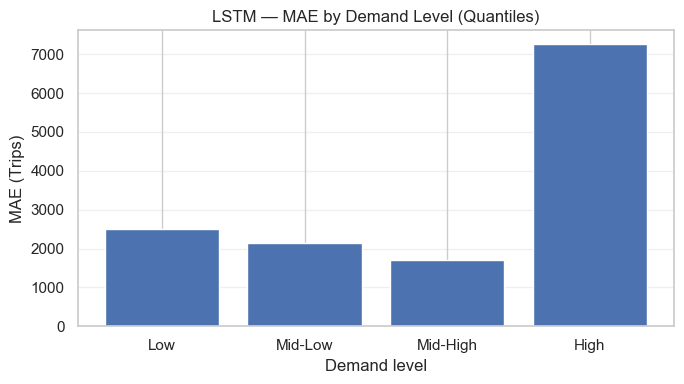


📊 ERROR BY DEMAND LEVEL (GRU)
DemandLevel  Samples  MeanActual      MAE     RMSE
        Low       72    4,012.03 2,613.69 3,595.76
    Mid-Low       72    6,879.87 3,224.78 3,753.58
   Mid-High       71   10,074.62 2,394.27 2,837.83
       High       72   21,375.83 5,434.08 6,854.38


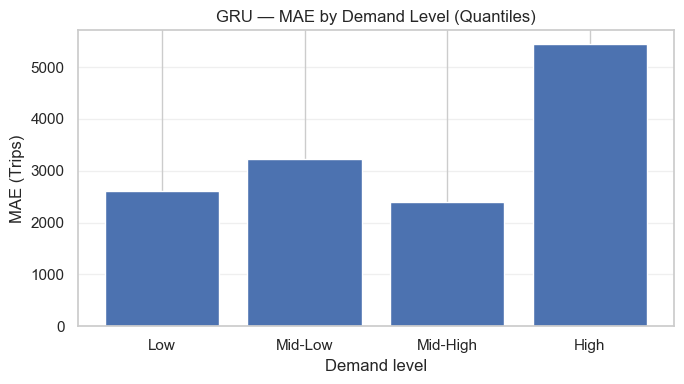

In [22]:
# Error Analysis by Demand Level (LSTM)
# Actual & predicted (Trips scale ήδη)
y = test_targets.ravel()
p = test_preds.ravel()

# Absolute error
abs_err = np.abs(y - p)

# Quantile bins (4 levels)
bins = np.quantile(y, [0, 0.25, 0.5, 0.75, 1.0])
bins[0]  -= 1e-6
bins[-1] += 1e-6

labels = ["Low", "Mid-Low", "Mid-High", "High"]

df_level = pd.DataFrame({
    "Actual": y,
    "Predicted": p,
    "AbsError": abs_err
})

df_level["DemandLevel"] = pd.cut(
    df_level["Actual"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Summary table per demand level
error_by_level_lstm = df_level.groupby("DemandLevel").agg(
    Samples=("AbsError", "size"),
    MeanActual=("Actual", "mean"),
    MAE=("AbsError", "mean"),
    RMSE=("AbsError", lambda e: float(np.sqrt(np.mean(e**2))))
).reset_index()

print("\n" + "="*70)
print("📊 ERROR BY DEMAND LEVEL (LSTM)")
print("="*70)
print(error_by_level_lstm.to_string(index=False, float_format=lambda x: f"{x:,.2f}"))

# Plot: MAE by demand level
plt.figure(figsize=(7, 4))
plt.bar(error_by_level_lstm["DemandLevel"].astype(str), error_by_level_lstm["MAE"])
plt.title("LSTM — MAE by Demand Level (Quantiles)")
plt.xlabel("Demand level")
plt.ylabel("MAE (Trips)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Error Analysis by Demand Level (GRU)
y = gru_test_targets.ravel()
p = gru_test_preds.ravel()
abs_err = np.abs(y - p)

bins = np.quantile(y, [0, 0.25, 0.5, 0.75, 1.0])
bins[0]  -= 1e-6
bins[-1] += 1e-6

labels = ["Low", "Mid-Low", "Mid-High", "High"]

df_level = pd.DataFrame({
    "Actual": y,
    "Predicted": p,
    "AbsError": abs_err
})

df_level["DemandLevel"] = pd.cut(
    df_level["Actual"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

error_by_level_gru = df_level.groupby("DemandLevel").agg(
    Samples=("AbsError", "size"),
    MeanActual=("Actual", "mean"),
    MAE=("AbsError", "mean"),
    RMSE=("AbsError", lambda e: float(np.sqrt(np.mean(e**2))))
).reset_index()

print("\n" + "="*70)
print("📊 ERROR BY DEMAND LEVEL (GRU)")
print("="*70)
print(error_by_level_gru.to_string(index=False, float_format=lambda x: f"{x:,.2f}"))

plt.figure(figsize=(7, 4))
plt.bar(error_by_level_gru["DemandLevel"].astype(str), error_by_level_gru["MAE"])
plt.title("GRU — MAE by Demand Level (Quantiles)")
plt.xlabel("Demand level")
plt.ylabel("MAE (Trips)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### 7.5.6. Timeline Reconstruction

In [23]:
# Train sequences start at: WARMUP_DAYS + SEQUENCE_LENGTH
train_start_idx = WARMUP_DAYS + SEQUENCE_LENGTH
train_end_idx   = train_start_idx + len(train_targets)

# Test sequences: first test target aligns with FIRST test day
test_start_idx  = WARMUP_DAYS + split_point
test_end_idx    = test_start_idx + len(test_targets)

# Extract dates
dates = pd.to_datetime(aggregated_daily_df['Date'])

train_dates = dates.iloc[train_start_idx:train_end_idx].reset_index(drop=True)
test_dates  = dates.iloc[test_start_idx:test_end_idx].reset_index(drop=True)

print(f"\n📅 Timeline Reconstruction")
print(f"   Train dates: {train_dates.iloc[0]} to {train_dates.iloc[-1]} ({len(train_dates)} days)")
print(f"   Test  dates: {test_dates.iloc[0]} to {test_dates.iloc[-1]} ({len(test_dates)} days)")

# Safety checks (prevents plotting / metric mismatch)
assert len(train_dates) == len(train_targets), \
    f"Mismatch train_dates={len(train_dates)} vs train_targets={len(train_targets)}"
assert len(test_dates) == len(test_targets), \
    f"Mismatch test_dates={len(test_dates)} vs test_targets={len(test_targets)}"

# Synthetic Days Diagnostics (reindex + interpolation)
if 'IsSynthetic' in aggregated_daily_df.columns:

    print("\n🔍 Synthetic Days Diagnostics")

    syn_mask = aggregated_daily_df['IsSynthetic'].astype(int) == 1
    syn_dates = pd.to_datetime(aggregated_daily_df.loc[syn_mask, 'Date'])

    total_syn = int(syn_mask.sum())
    print(f"   Total synthetic days (whole dataset): {total_syn}")

    if total_syn > 0:
        print(f"   Synthetic date range: {syn_dates.min()} → {syn_dates.max()}")

        # Check overlap with evaluation windows
        train_start_date, train_end_date = train_dates.iloc[0], train_dates.iloc[-1]
        test_start_date,  test_end_date  = test_dates.iloc[0],  test_dates.iloc[-1]

        syn_in_train = ((syn_dates >= train_start_date) & (syn_dates <= train_end_date)).sum()
        syn_in_test  = ((syn_dates >= test_start_date)  & (syn_dates <= test_end_date)).sum()

        print(f"\n📊 Synthetic days inside evaluation windows:")
        print(f"   Train window: {int(syn_in_train)} synthetic days")
        print(f"   Test  window: {int(syn_in_test)} synthetic days")

        if syn_in_test > 0:
            print(
                f"\n⚠️  Note: Test metrics include {int(syn_in_test)} synthetic days\n"
                f"    (calendar reindex + time interpolation / hybrid imputation).\n"
                f"    Results may slightly overestimate real-world accuracy."
            )
        else:
            print(
                f"\n✅ No synthetic days inside TEST window.\n"
                f"   Test metrics are based entirely on real observed days."
            )

    else:
        print("   ✅ No synthetic days detected in dataset.")

else:
    print("\n✅ No 'IsSynthetic' column found — dataset contains only observed days.")



📅 Timeline Reconstruction
   Train dates: 2018-07-12 00:00:00 to 2021-06-21 00:00:00 (1076 days)
   Test  dates: 2021-06-22 00:00:00 to 2022-04-04 00:00:00 (287 days)

🔍 Synthetic Days Diagnostics
   Total synthetic days (whole dataset): 23
   Synthetic date range: 2018-04-29 00:00:00 → 2018-05-22 00:00:00

📊 Synthetic days inside evaluation windows:
   Train window: 0 synthetic days
   Test  window: 0 synthetic days

✅ No synthetic days inside TEST window.
   Test metrics are based entirely on real observed days.


### 7.5.7. Model Comparison and Visualisation

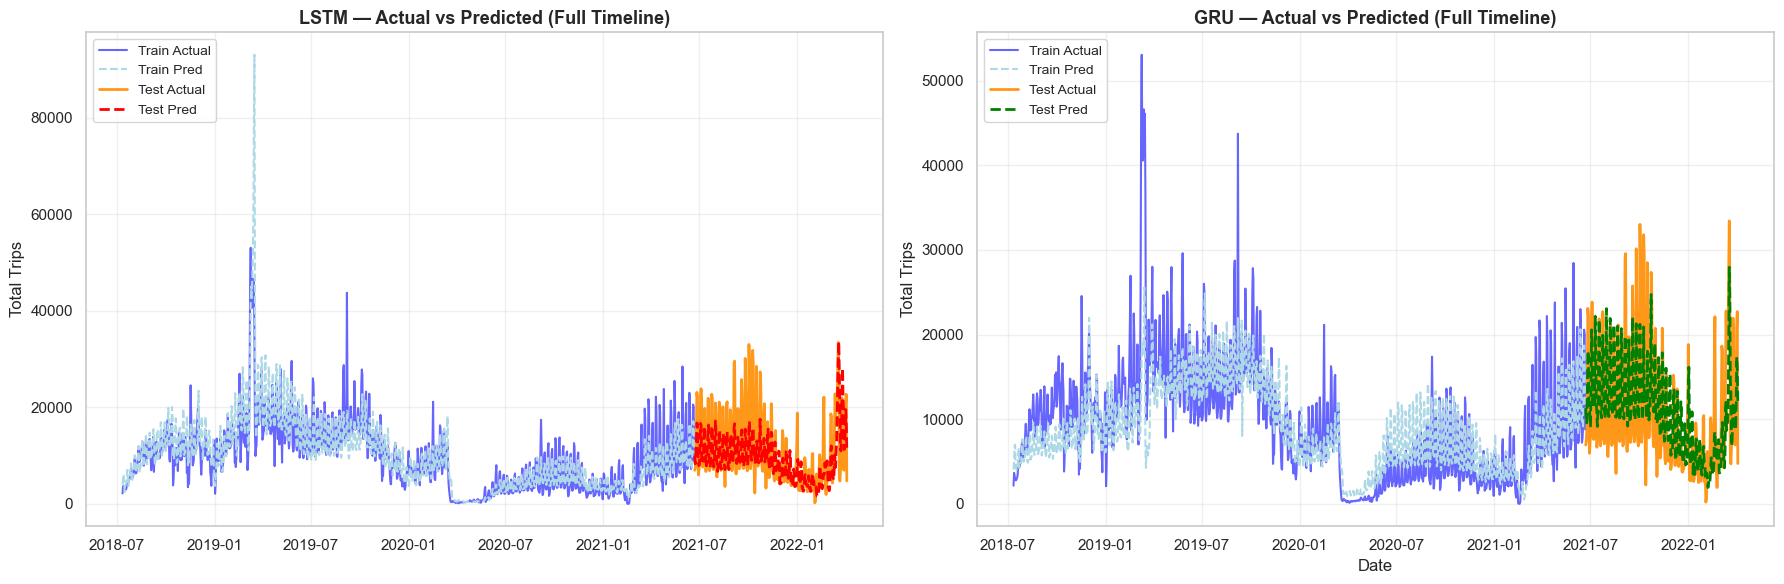

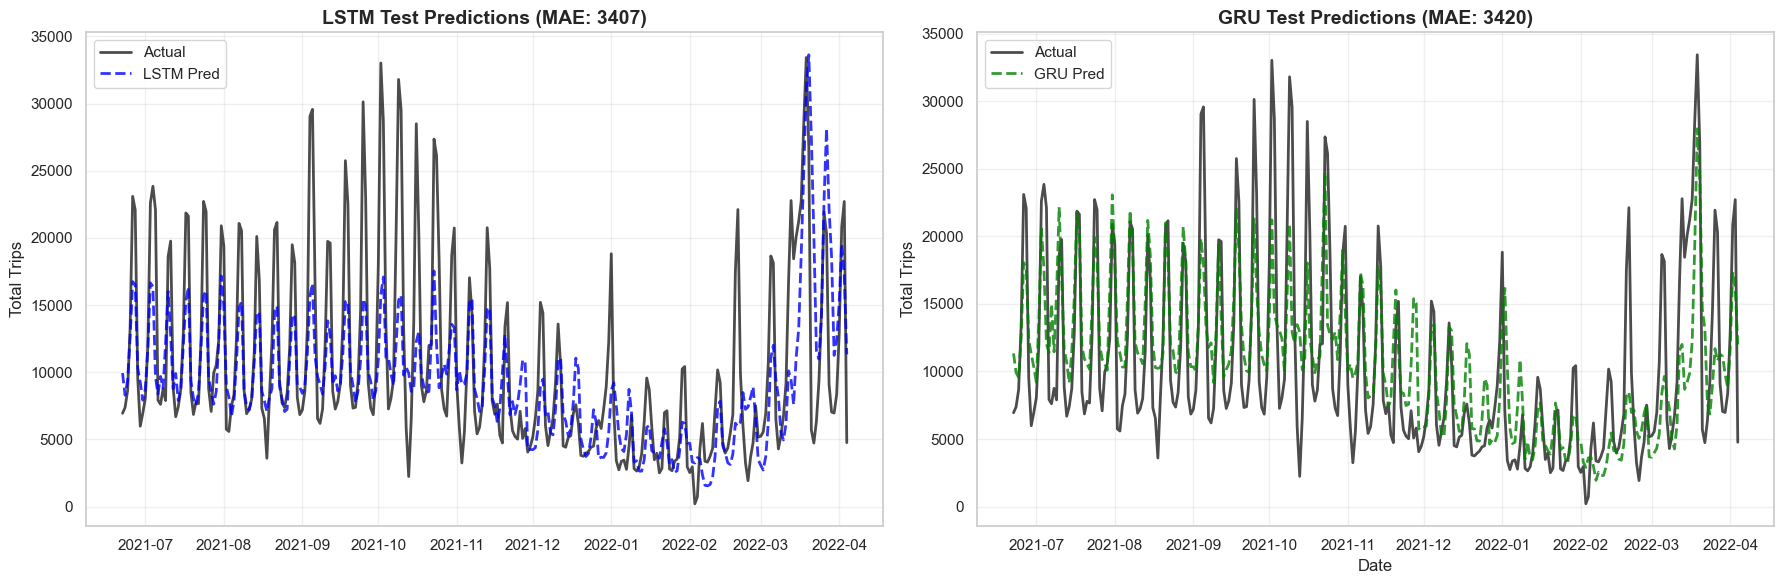

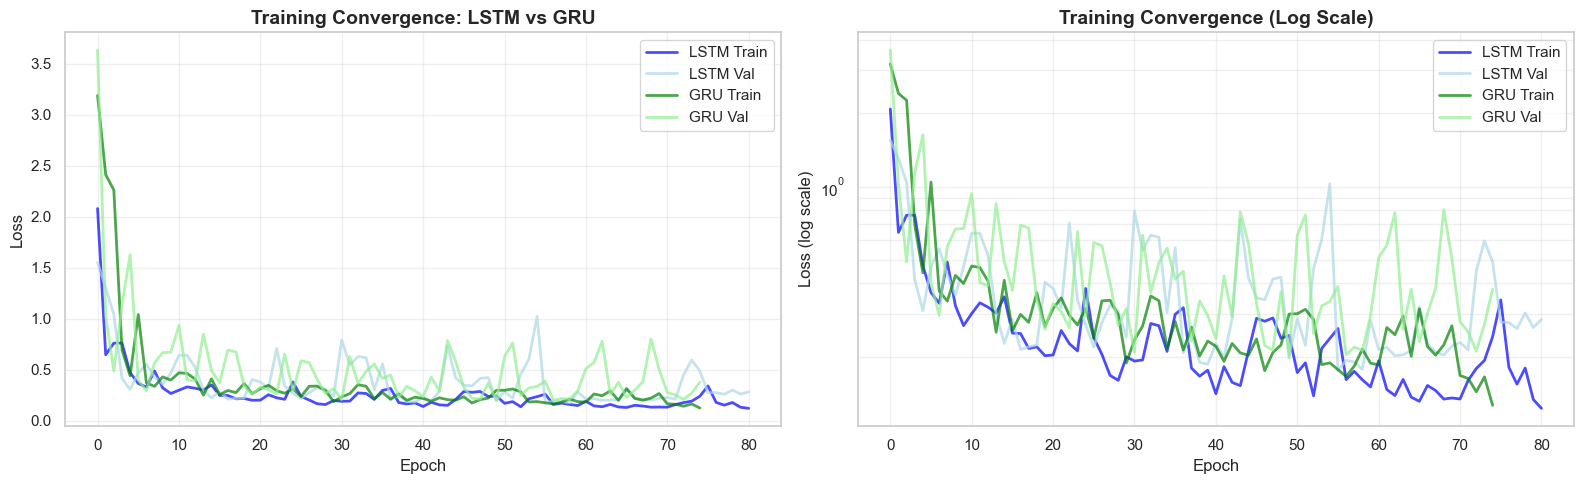

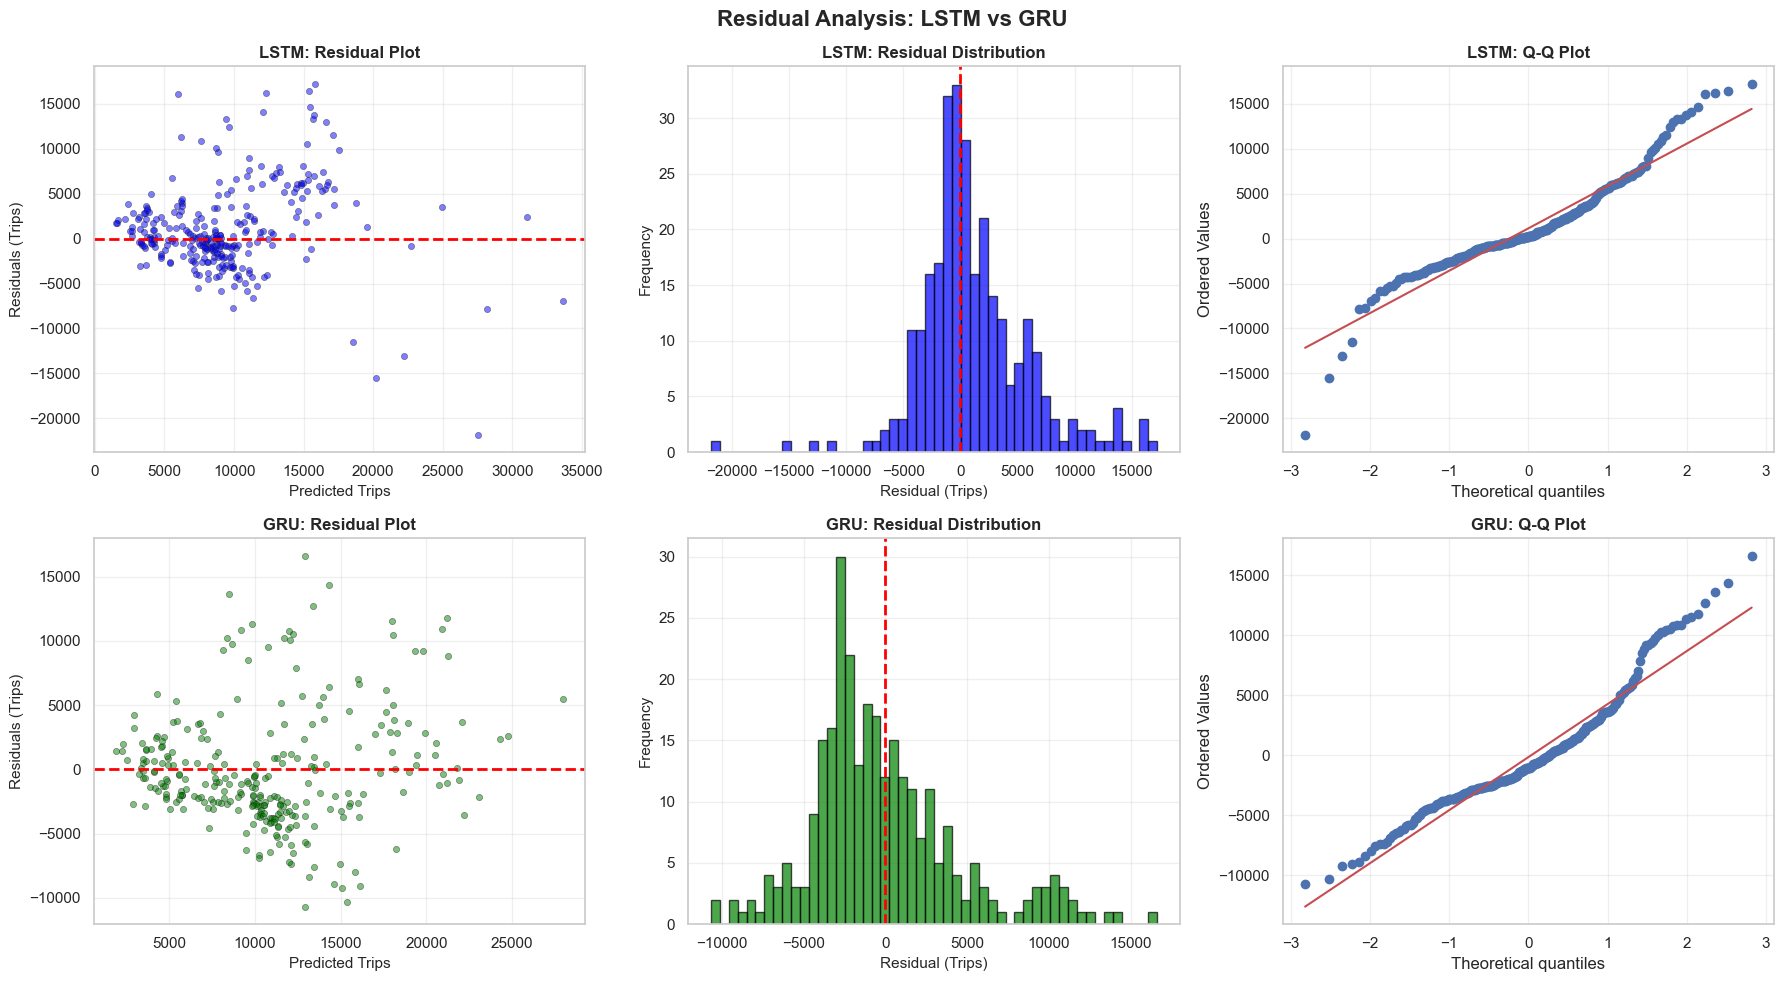

In [24]:
# Plot 1: Full Timeline (Train + Test)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# LSTM
axes[0].plot(train_dates, train_targets, label='Train Actual',
             color='blue', alpha=0.6, lw=1.5)
axes[0].plot(train_dates, train_preds, label='Train Pred',
             color='lightblue', ls='--', lw=1.5)
axes[0].plot(test_dates, test_targets, label='Test Actual',
             color='darkorange', alpha=0.9, lw=2.0)
axes[0].plot(test_dates, test_preds, label='Test Pred',
             color='red', ls='--', lw=2.0)
axes[0].set_title("LSTM — Actual vs Predicted (Full Timeline)",
                  fontsize=13, fontweight='bold')
axes[0].set_ylabel("Total Trips", fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper left', fontsize=10)

# GRU
axes[1].plot(train_dates, gru_train_targets, label='Train Actual',
             color='blue', alpha=0.6, lw=1.5)
axes[1].plot(train_dates, gru_train_preds, label='Train Pred',
             color='lightblue', ls='--', lw=1.5)
axes[1].plot(test_dates, gru_test_targets, label='Test Actual',
             color='darkorange', alpha=0.9, lw=2.0)
axes[1].plot(test_dates, gru_test_preds, label='Test Pred',
             color='green', ls='--', lw=2.0)
axes[1].set_title("GRU — Actual vs Predicted (Full Timeline)",
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel("Date", fontsize=12)
axes[1].set_ylabel("Total Trips", fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()


# Plot 2: Test Set Predictions (Side-by-Side)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# LSTM Test
axes[0].plot(test_dates, test_targets, label='Actual',
             color='black', alpha=0.7, linewidth=2)
axes[0].plot(test_dates, test_preds, label='LSTM Pred',
             color='blue', linestyle='--', linewidth=2, alpha=0.8)
axes[0].set_title(f"LSTM Test Predictions (MAE: {lstm_test_mae:.0f})",
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel("Total Trips", fontsize=12)
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(True, alpha=0.3)

# GRU Test
axes[1].plot(test_dates, gru_test_targets, label='Actual',
             color='black', alpha=0.7, linewidth=2)
axes[1].plot(test_dates, gru_test_preds, label='GRU Pred',
             color='green', linestyle='--', linewidth=2, alpha=0.8)
axes[1].set_title(f"GRU Test Predictions (MAE: {gru_test_mae:.0f})",
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel("Date", fontsize=12)
axes[1].set_ylabel("Total Trips", fontsize=12)
axes[1].legend(loc='upper left', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Plot 3: Training Convergence Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Linear scale
axes[0].plot(lstm_train_losses, label='LSTM Train',
             color='blue', linewidth=2, alpha=0.7)
axes[0].plot(lstm_val_losses, label='LSTM Val',
             color='lightblue', linewidth=2, alpha=0.7)
axes[0].plot(gru_train_losses, label='GRU Train',
             color='green', linewidth=2, alpha=0.7)
axes[0].plot(gru_val_losses, label='GRU Val',
             color='lightgreen', linewidth=2, alpha=0.7)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Convergence: LSTM vs GRU',
                  fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].plot(lstm_train_losses, label='LSTM Train',
             color='blue', linewidth=2, alpha=0.7)
axes[1].plot(lstm_val_losses, label='LSTM Val',
             color='lightblue', linewidth=2, alpha=0.7)
axes[1].plot(gru_train_losses, label='GRU Train',
             color='green', linewidth=2, alpha=0.7)
axes[1].plot(gru_val_losses, label='GRU Val',
             color='lightgreen', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss (log scale)', fontsize=12)
axes[1].set_yscale('log')
axes[1].set_title('Training Convergence (Log Scale)',
                  fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()


# Plot 4: Residual Analysis
assert len(test_targets) == len(test_preds), "Mismatch in LSTM test arrays!"
assert len(gru_test_targets) == len(gru_test_preds), "Mismatch in GRU test arrays!"

lstm_residuals = test_targets - test_preds
gru_residuals  = gru_test_targets - gru_test_preds

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Residual Analysis: LSTM vs GRU', fontsize=16, fontweight='bold')

# LSTM residuals
axes[0, 0].scatter(test_preds, lstm_residuals, alpha=0.5,
                   color='blue', edgecolors='k', linewidth=0.5, s=20)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('LSTM: Residual Plot', fontweight='bold', fontsize=12)
axes[0, 0].set_xlabel('Predicted Trips', fontsize=11)
axes[0, 0].set_ylabel('Residuals (Trips)', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(lstm_residuals, bins=50, edgecolor='black',
                color='blue', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('LSTM: Residual Distribution', fontweight='bold', fontsize=12)
axes[0, 1].set_xlabel('Residual (Trips)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

stats.probplot(lstm_residuals, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('LSTM: Q-Q Plot', fontweight='bold', fontsize=12)
axes[0, 2].grid(True, alpha=0.3)

# GRU residuals
axes[1, 0].scatter(gru_test_preds, gru_residuals, alpha=0.5,
                   color='green', edgecolors='k', linewidth=0.5, s=20)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_title('GRU: Residual Plot', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('Predicted Trips', fontsize=11)
axes[1, 0].set_ylabel('Residuals (Trips)', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(gru_residuals, bins=50, edgecolor='black',
                color='green', alpha=0.7)
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_title('GRU: Residual Distribution', fontweight='bold', fontsize=12)
axes[1, 1].set_xlabel('Residual (Trips)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

stats.probplot(gru_residuals, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('GRU: Q-Q Plot', fontweight='bold', fontsize=12)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 7.5.8. Summary Statistics

In [25]:
print("\n" + "="*70)
print("📊 RESIDUAL ANALYSIS SUMMARY")
print("="*70)

print(f"\nLSTM Residuals:")
print(f"   Mean:   {np.mean(lstm_residuals):8.2f}")
print(f"   Std:    {np.std(lstm_residuals):8.2f}")
print(f"   Min:    {np.min(lstm_residuals):8.2f}")
print(f"   Max:    {np.max(lstm_residuals):8.2f}")
print(f"   Median: {np.median(lstm_residuals):8.2f}")

print(f"\nGRU Residuals:")
print(f"   Mean:   {np.mean(gru_residuals):8.2f}")
print(f"   Std:    {np.std(gru_residuals):8.2f}")
print(f"   Min:    {np.min(gru_residuals):8.2f}")
print(f"   Max:    {np.max(gru_residuals):8.2f}")
print(f"   Median: {np.median(gru_residuals):8.2f}")

print("\n" + "="*70)
print(f"\n📁 Saved Artifacts:")
print(f"   - lstm_demand_model.pth (trained LSTM weights)")
print(f"   - gru_demand_model.pth (trained GRU weights)")


📊 RESIDUAL ANALYSIS SUMMARY

LSTM Residuals:
   Mean:    1142.81
   Std:     4863.69
   Min:    -21831.67
   Max:    17234.76
   Median:   218.91

GRU Residuals:
   Mean:    -145.82
   Std:     4531.65
   Min:    -10684.44
   Max:    16628.68
   Median: -1024.44


📁 Saved Artifacts:
   - lstm_demand_model.pth (trained LSTM weights)
   - gru_demand_model.pth (trained GRU weights)


# 8. Production Inference System
## 8.1. Model Loader Class

In [26]:
class ModelLoader:
    """Φορτώνει το εκπαιδευμένο LSTM/GRU μοντέλο και τα preprocessing artifacts."""

    def __init__(self, model_type='lstm', model_dir='models'):
        """
        Args:
            model_type: 'lstm' ή 'gru'
            model_dir: Φάκελος όπου βρίσκονται τα .pth files
        """
        self.model_type = model_type.lower()
        self.model_dir = model_dir

        # Paths
        self.model_path = os.path.join(model_dir, f'{self.model_type}_demand_model.pth')
        self.scaler_path = os.path.join(model_dir, 'feature_scaler.pkl')
        self.features_path = os.path.join(model_dir, 'input_features.json')

        # Check that files exist
        self._check_files()

        # Load artifacts
        self.feature_scaler = self._load_scaler()
        self.input_features = self._load_features()

        # Load model
        self.model = self._load_model()

    def _check_files(self):
        missing = []
        for p in [self.model_path, self.scaler_path, self.features_path]:
            if not os.path.exists(p):
                missing.append(p)
        if missing:
            raise FileNotFoundError(
                "❌ Missing required files:\n" +
                "\n".join(f"  - {f}" for f in missing) +
                "\n\n💡 Run Section 7 first to generate these files."
            )

    def _load_scaler(self):
        """Φορτώνει τον StandardScaler."""
        with open(self.scaler_path, 'rb') as f:
            return pickle.load(f)

    def _load_features(self):
        """Φορτώνει τα ονόματα των features."""
        with open(self.features_path, 'r') as f:
            return json.load(f)

    def _load_model(self):
        """
        Φορτώνει το εκπαιδευμένο μοντέλο.
        Χρησιμοποιεί τα GLOBAL hyperparameters από το Section 7.
        """
        INPUT_SIZE_INFERENCE = len(self.input_features)
    
        if self.model_type == 'lstm':
            model = TwoWheelerLSTM(
                input_size=INPUT_SIZE_INFERENCE,
                hidden_size=HIDDEN_SIZE,
                num_layers=NUM_LAYERS,
                output_size=OUTPUT_SIZE,
                dropout_rate=DROPOUT_RATE
            )
        elif self.model_type == 'gru':
            model = TwoWheelerGRU(
                input_size=INPUT_SIZE_INFERENCE,
                hidden_size=HIDDEN_SIZE,
                num_layers=NUM_LAYERS,
                output_size=OUTPUT_SIZE,
                dropout_rate=DROPOUT_RATE
            )
        else:
            raise ValueError("model_type must be 'lstm' or 'gru'")
    
        # CPU-only load
        state = torch.load(self.model_path, map_location='cpu')
        model.load_state_dict(state)
        model.eval()
        return model

## 8.2. Data Preprocessor

In [27]:
class DemandPreprocessor:
    """Προετοιμάζει daily raw δεδομένα για inference."""

    def __init__(self, feature_names, scaler):
        self.feature_names   = feature_names
        self.scaler          = scaler
        self.sequence_length = SEQUENCE_LENGTH  # global από training

    def prepare_data(self, df):
        """
        Μετατρέπει daily-format input σε model-ready format.

        Args:
            Απαιτεί τουλάχιστον: Date + TotalTrips
            και ό,τι άλλο υπάρχει από:
            TotalUniqueDevices, MedianDuration, MedianDistance,
            AvgDuration, StdDuration, AvgDistance, StdDistance, PeakHour

        Returns:
            X_tensor: (1, seq_len, features)
            last_date: τελευταία ημερομηνία
            df_proc: processed df (για iterative forecasting)
        """

        # 1) Sort + index ημερομηνίας
        df = df.copy()

        if 'Date' not in df.columns:
            raise ValueError("❌ Inference input must include 'Date' column.")
        if 'TotalTrips' not in df.columns:
            raise ValueError("❌ Inference input must include 'TotalTrips' column.")

        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)

        # 2) Reindex πλήρες ημερολόγιο (κρατάμε NaN για τα missing days)
        df = df.set_index('Date')
        full_idx  = pd.date_range(df.index.min(), df.index.max(), freq='D')
        df_filled = df.reindex(full_idx)

        # 3) Flag synthetic days BEFORE imputation
        df_filled['IsSynthetic'] = df_filled['TotalTrips'].isna().astype(int)

        # 4) Calendar features από index (ίδια λογική με Section 5)
        df_filled['DayOfWeek'] = df_filled.index.dayofweek
        df_filled['Month']     = df_filled.index.month
        df_filled['Season']    = df_filled['Month'].map(month_to_season)

        # Cyclical encodings
        df_filled['DayOfWeek_sin'] = np.sin(2 * np.pi * df_filled['DayOfWeek'] / 7)
        df_filled['DayOfWeek_cos'] = np.cos(2 * np.pi * df_filled['DayOfWeek'] / 7)
        df_filled['Month_sin']     = np.sin(2 * np.pi * df_filled['Month'] / 12)
        df_filled['Month_cos']     = np.cos(2 * np.pi * df_filled['Month'] / 12)
        df_filled['Season_sin']    = np.sin(2 * np.pi * df_filled['Season'] / 4)
        df_filled['Season_cos']    = np.cos(2 * np.pi * df_filled['Season'] / 4)

        # 5) Missing value handling (HYBRID / INTERPOLATION)
        # (A) TotalTrips -> log-interpolation + round
        tmp = np.log1p(df_filled['TotalTrips'])
        tmp = tmp.interpolate(method='time').ffill().bfill()
        df_filled['TotalTrips'] = np.expm1(tmp).clip(lower=0).round()

        # (B) TotalUniqueDevices (αν υπάρχει) -> time interpolation + round
        if 'TotalUniqueDevices' in df_filled.columns:
            df_filled['TotalUniqueDevices'] = (
                df_filled['TotalUniqueDevices']
                    .interpolate(method='time')
                    .ffill()
                    .bfill()
                    .clip(lower=0)
                    .round()
            )

        # (C) Continuous vars (αν υπάρχουν) -> time interpolation
        cont_cols = []
        for c in [
            'MedianDuration', 'MedianDistance',
            'AvgDuration', 'StdDuration',
            'AvgDistance', 'StdDistance'
        ]:
            if c in df_filled.columns:
                cont_cols.append(c)

        if cont_cols:
            df_filled[cont_cols] = (
                df_filled[cont_cols]
                    .interpolate(method='time')
                    .ffill()
                    .bfill()
            )

        # If TotalTrips==0 -> continuous vars not meaningful -> set to 0
        zero_trip_mask = (df_filled['TotalTrips'] == 0)
        if cont_cols:
            df_filled.loc[zero_trip_mask, cont_cols] = 0

        # (D) PeakHour (αν υπάρχει) -> ffill/bfill (no interpolation), clamp
        if 'PeakHour' in df_filled.columns:
            df_filled['PeakHour'] = (
                df_filled['PeakHour']
                    .ffill()
                    .bfill()
                    .fillna(0)
                    .round()
                    .clip(0, 23)
            )
            # προαιρετικά (ίδια λογική με Section 5)
            df_filled.loc[zero_trip_mask, 'PeakHour'] = 0

        # 6) Back to DataFrame (Date column)
        df_proc = df_filled.reset_index().rename(columns={'index': 'Date'})
        df_proc = df_proc.sort_values('Date').reset_index(drop=True)

        # 7) Engineered features (MUST match Section 5.8 logic)
        
        # DayType
        df_proc['DayType'] = (df_proc['DayOfWeek'] >= 5).astype(int)
        
        # Demand lags
        df_proc['TotalTrips_Lag1']  = df_proc['TotalTrips'].shift(1).fillna(0)
        df_proc['TotalTrips_Lag7']  = df_proc['TotalTrips'].shift(7).fillna(0)
        df_proc['TotalTrips_Lag14'] = df_proc['TotalTrips'].shift(14).fillna(0)
        
        # Rolling means
        df_proc['TotalTrips_Roll7']  = df_proc['TotalTrips'].shift(1).rolling(7,  min_periods=1).mean()
        df_proc['TotalTrips_Roll30'] = df_proc['TotalTrips'].shift(1).rolling(30, min_periods=1).mean()
        df_proc['Trend14']           = df_proc['TotalTrips'].shift(1).rolling(14, min_periods=1).mean()
        
        # EMA
        df_proc['TotalTrips_EMA7']  = df_proc['TotalTrips'].ewm(span=7, adjust=False).mean().shift(1)
        df_proc['TotalTrips_EMA30'] = df_proc['TotalTrips'].ewm(span=30, adjust=False).mean().shift(1)
        
        # Momentum
        den = df_proc['TotalTrips'].shift(7).replace(0, np.nan)
        df_proc['Momentum7'] = ((df_proc['TotalTrips'] - df_proc['TotalTrips'].shift(7)) / den).replace([np.inf, -np.inf], np.nan)
        df_proc['Momentum7'] = df_proc['Momentum7'].shift(1).fillna(0)
        
        # Volatility
        df_proc['TotalTrips_Std7'] = df_proc['TotalTrips'].rolling(7, min_periods=2).std().shift(1).fillna(0)
        
        # Devices
        if 'TotalUniqueDevices' in df_proc.columns:
            df_proc['Devices_Lag1']   = df_proc['TotalUniqueDevices'].shift(1).fillna(0)
            df_proc['Devices_Lag7']   = df_proc['TotalUniqueDevices'].shift(7).fillna(0)
            df_proc['Devices_Roll7']  = df_proc['TotalUniqueDevices'].shift(1).rolling(7,  min_periods=1).mean()
            df_proc['Devices_Roll30'] = df_proc['TotalUniqueDevices'].shift(1).rolling(30, min_periods=1).mean()
        else:
            df_proc['Devices_Lag1'] = 0.0
            df_proc['Devices_Lag7'] = 0.0
            df_proc['Devices_Roll7'] = 0.0
            df_proc['Devices_Roll30'] = 0.0
        
        # Trip characteristics (if present)
        for col in ['MedianDistance','MedianDuration']:
            if col not in df_proc.columns:
                df_proc[col] = 0.0
        
        df_proc['MedianDistance_Lag1']  = df_proc['MedianDistance'].shift(1).fillna(0)
        df_proc['MedianDistance_Lag7']  = df_proc['MedianDistance'].shift(7).fillna(0)
        df_proc['MedianDistance_Roll7'] = df_proc['MedianDistance'].shift(1).rolling(7, min_periods=1).mean().fillna(0)
        
        df_proc['MedianDuration_Lag1']  = df_proc['MedianDuration'].shift(1).fillna(0)
        df_proc['MedianDuration_Lag7']  = df_proc['MedianDuration'].shift(7).fillna(0)
        df_proc['MedianDuration_Roll7'] = df_proc['MedianDuration'].shift(1).rolling(7, min_periods=1).mean().fillna(0)

        # 8) Ensure ALL required features exist (για να μη σπάσει αν αλλάξουν input_features)
        for f in self.feature_names:
            if f not in df_proc.columns:
                df_proc[f] = 0.0

        # 9) Length check
        if len(df_proc) < self.sequence_length:
            raise ValueError(
                f"❌ Need at least {self.sequence_length} days of data, got {len(df_proc)}."
            )

        # 10) Extract τελευταίο sequence
        recent = df_proc.tail(self.sequence_length)
        X = recent[self.feature_names].values.astype(np.float32)

        # 11) Αν κάτι έμεινε NaN/inf -> 0 (για να μην “σκάσει” το iterative loop)
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

        # 12) Scaling
        X_scaled = self.scaler.transform(X)

        # 13) Tensor
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32).unsqueeze(0)

        # 14) last_date
        last_date = df_proc['Date'].iloc[-1]

        return X_tensor, last_date, df_proc


## 8.3. Weekly Forecaster

In [28]:
class WeeklyForecaster:
    """
    Παράγει πρόβλεψη για τις επόμενες 7 ημέρες.
    Iterative one-step forecasting: κάθε νέα πρόβλεψη μπαίνει πίσω στη σειρά.
    """

    def __init__(self, model_loader):
        self.model = model_loader.model
        self.preprocessor = DemandPreprocessor(
            feature_names=model_loader.input_features,
            scaler=model_loader.feature_scaler
        )

    def predict_week(self, df):
        """
        Προβλέπει ζήτηση για τις επόμενες 7 ημέρες.
        
        Args:
            df: Ιστορικά δεδομένα (minimum 60 ημέρες) με columns
        Returns:
            forecast_df
        """
        # 1) Preparation input (Section 8.2)
        X, last_date, hist_df = self.preprocessor.prepare_data(df)

        # 2) Creation of forecast dates
        current_sequence = X.clone()  # (1, seq_len, features)

        forecast_dates = [last_date + timedelta(days=i + 1) for i in range(7)]
        predictions = []

        # Helper: κρατάμε σταθερά όσα δεν μπορούμε να προβλέψουμε (supply/characteristics)
        def _safe_last(col, default=0.0):
            if col in hist_df.columns and len(hist_df[col]) > 0:
                v = hist_df[col].iloc[-1]
                return float(0.0 if pd.isna(v) else v)
            return float(default)

        for target_date in forecast_dates:
            # 3) Predict (log-space output)
            with torch.no_grad():
                pred_log = self.model(current_sequence).detach().numpy().ravel()[0]

            pred_trips = float(np.expm1(pred_log))
            pred_trips = max(pred_trips, 0.0)
            predictions.append(pred_trips)

            # 4) Append predicted day (κρατάμε σταθερά όσα χρειάζονται για features)
            new_row = {'Date': target_date, 'TotalTrips': pred_trips}

            # Αν υπάρχουν αυτά τα cols στο training/features, τα γεμίζουμε σταθερά για future days
            for col in ['TotalUniqueDevices', 'MedianDuration', 'MedianDistance', 'PeakHour',
                        'AvgDuration', 'AvgDistance', 'StdDuration', 'StdDistance']:
                if col in hist_df.columns:
                    new_row[col] = _safe_last(col, default=0.0)

            hist_df = pd.concat([hist_df, pd.DataFrame([new_row])], ignore_index=True)

            # 5) Recompute Engineered Columns (MUST match training)
            hist_df['Date'] = pd.to_datetime(hist_df['Date'])
            hist_df = hist_df.sort_values('Date').reset_index(drop=True)
            
            hist_df['DayOfWeek'] = hist_df['Date'].dt.dayofweek
            hist_df['Month']     = hist_df['Date'].dt.month
            hist_df['Season']    = hist_df['Month'].map(month_to_season)
            
            hist_df['DayOfWeek_sin'] = np.sin(2 * np.pi * hist_df['DayOfWeek'] / 7)
            hist_df['DayOfWeek_cos'] = np.cos(2 * np.pi * hist_df['DayOfWeek'] / 7)
            hist_df['Month_sin']     = np.sin(2 * np.pi * hist_df['Month'] / 12)
            hist_df['Month_cos']     = np.cos(2 * np.pi * hist_df['Month'] / 12)
            hist_df['Season_sin']    = np.sin(2 * np.pi * hist_df['Season'] / 4)
            hist_df['Season_cos']    = np.cos(2 * np.pi * hist_df['Season'] / 4)
            
            hist_df['DayType'] = (hist_df['DayOfWeek'] >= 5).astype(int)
            
            # Demand lags
            hist_df['TotalTrips_Lag1']  = hist_df['TotalTrips'].shift(1).fillna(0)
            hist_df['TotalTrips_Lag7']  = hist_df['TotalTrips'].shift(7).fillna(0)
            hist_df['TotalTrips_Lag14'] = hist_df['TotalTrips'].shift(14).fillna(0)
            
            # Rolling
            hist_df['TotalTrips_Roll7']  = hist_df['TotalTrips'].shift(1).rolling(7,  min_periods=1).mean()
            hist_df['TotalTrips_Roll30'] = hist_df['TotalTrips'].shift(1).rolling(30, min_periods=1).mean()
            hist_df['Trend14']           = hist_df['TotalTrips'].shift(1).rolling(14, min_periods=1).mean()
            
            # EMA
            hist_df['TotalTrips_EMA7']  = hist_df['TotalTrips'].ewm(span=7, adjust=False).mean().shift(1)
            hist_df['TotalTrips_EMA30'] = hist_df['TotalTrips'].ewm(span=30, adjust=False).mean().shift(1)
            
            # Momentum
            den = hist_df['TotalTrips'].shift(7).replace(0, np.nan)
            hist_df['Momentum7'] = ((hist_df['TotalTrips'] - hist_df['TotalTrips'].shift(7)) / den).replace([np.inf, -np.inf], np.nan)
            hist_df['Momentum7'] = hist_df['Momentum7'].shift(1).fillna(0)
            
            # Volatility
            hist_df['TotalTrips_Std7'] = hist_df['TotalTrips'].rolling(7, min_periods=2).std().shift(1).fillna(0)
            
            # Devices (if exists)
            if 'TotalUniqueDevices' in hist_df.columns:
                hist_df['Devices_Lag1']   = hist_df['TotalUniqueDevices'].shift(1).fillna(0)
                hist_df['Devices_Lag7']   = hist_df['TotalUniqueDevices'].shift(7).fillna(0)
                hist_df['Devices_Roll7']  = hist_df['TotalUniqueDevices'].shift(1).rolling(7,  min_periods=1).mean()
                hist_df['Devices_Roll30'] = hist_df['TotalUniqueDevices'].shift(1).rolling(30, min_periods=1).mean()
            else:
                hist_df['Devices_Lag1'] = 0.0
                hist_df['Devices_Lag7'] = 0.0
                hist_df['Devices_Roll7'] = 0.0
                hist_df['Devices_Roll30'] = 0.0
            
            # Trip characteristics
            for col in ['MedianDistance','MedianDuration']:
                if col not in hist_df.columns:
                    hist_df[col] = 0.0
            
            hist_df['MedianDistance_Lag1']  = hist_df['MedianDistance'].shift(1).fillna(0)
            hist_df['MedianDistance_Lag7']  = hist_df['MedianDistance'].shift(7).fillna(0)
            hist_df['MedianDistance_Roll7'] = hist_df['MedianDistance'].shift(1).rolling(7, min_periods=1).mean().fillna(0)
            
            hist_df['MedianDuration_Lag1']  = hist_df['MedianDuration'].shift(1).fillna(0)
            hist_df['MedianDuration_Lag7']  = hist_df['MedianDuration'].shift(7).fillna(0)
            hist_df['MedianDuration_Roll7'] = hist_df['MedianDuration'].shift(1).rolling(7, min_periods=1).mean().fillna(0)

            # 6) Ensure ALL required features exist
            for f in self.preprocessor.feature_names:
                if f not in hist_df.columns:
                    hist_df[f] = 0.0

            # 7) Build next feature vector in EXACT training feature order
            next_features = hist_df.iloc[-1][self.preprocessor.feature_names].values.astype(np.float32).reshape(1, -1)
            next_features = np.nan_to_num(next_features, nan=0.0, posinf=0.0, neginf=0.0)

            # Scale
            next_scaled = self.preprocessor.scaler.transform(next_features)

            # Roll Sequence Window
            next_tensor = torch.tensor(next_scaled, dtype=torch.float32).unsqueeze(0)
            current_sequence = torch.cat([current_sequence[:, 1:, :], next_tensor], dim=1)

        forecast_df = pd.DataFrame({
            'Date': forecast_dates,
            'Predicted_Trips': predictions,
            'DayOfWeek': [d.strftime('%A') for d in forecast_dates]
        })

        return forecast_df

## 8.4. Main Inference Function

In [29]:
def forecast_demand(csv_path, model_type='lstm', plot=True):
    """
    Πλήρης inference pipeline.
    Εδώ φορτώνουμε daily-format CSV για χρήση σε production-like forecasting.
    """
    print("\n" + "="*70)
    print("🚀 MICROMOBILITY DEMAND FORECASTING SYSTEM")
    print("="*70)

    # 1) Load data
    df = pd.read_csv(csv_path, parse_dates=['Date'])

    # Προσοχή: τα required εδώ είναι ΜΟΝΟ όσα χρειάζεται για να δουλέψει το 8.2/8.3.
    # Αν κάποια raw cols λείπουν, απλά δεν θα χρησιμοποιηθούν (feature-safe),αρκεί να υπάρχουν τα features που ζητάει input_features.json μετά το prepare_data().
    if 'Date' not in df.columns or 'TotalTrips' not in df.columns:
        raise ValueError("❌ CSV must contain at least ['Date', 'TotalTrips'].")

    print(f"✅ Loaded {len(df)} rows")
    print(f"   Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")

    # 2) Load model + artifacts
    loader = ModelLoader(model_type=model_type)

    # 3) Forecast
    forecaster = WeeklyForecaster(loader)
    forecast_df = forecaster.predict_week(df)

    # 4) Print results (Monday → Sunday order)
    weekday_order = [
        'Monday', 'Tuesday', 'Wednesday',
        'Thursday', 'Friday', 'Saturday', 'Sunday'
    ]

    forecast_print = forecast_df.copy()
    forecast_print['DayOfWeek'] = pd.Categorical(
        forecast_print['DayOfWeek'],
        categories=weekday_order,
        ordered=True
    )
    forecast_print = forecast_print.sort_values('DayOfWeek')

    print("\n" + "="*70)
    print("📊 FORECAST RESULTS (Next 7 Days)")
    print("="*70)
    print(forecast_print.to_string(index=False, float_format=lambda x: f'{x:,.0f}'))
    print("="*70)

    # 5) Plot
    if plot:
        _plot_forecast(df, forecast_df, model_type)

    return forecast_df


def _plot_forecast(historical_df, forecast_df, model_type):
    """Plot history + forecast (simple, clean)"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    hist = historical_df.copy()
    hist['Date'] = pd.to_datetime(hist['Date'])
    hist = hist.sort_values('Date')
    recent = hist.tail(90).copy()

    # (1) Timeline
    axes[0].plot(recent['Date'], recent['TotalTrips'], label='Historical', linewidth=2, alpha=0.8)
    axes[0].plot(forecast_df['Date'], forecast_df['Predicted_Trips'], label='Forecast',
                 linestyle='--', marker='o', linewidth=2, alpha=0.9)
    axes[0].axvline(recent['Date'].iloc[-1], linestyle=':', linewidth=2, alpha=0.7, label='Last observed day')
    axes[0].set_title(f'Demand Forecast — {model_type.upper()} (Next 7 Days)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Date')
    axes[0].set_ylabel('Total Trips')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper left')

    # (2) Bars by weekday (Monday → Sunday order)
    weekday_order = [
        'Monday', 'Tuesday', 'Wednesday',
        'Thursday', 'Friday', 'Saturday', 'Sunday'
    ]

    forecast_plot = forecast_df.copy()
    forecast_plot['DayOfWeek'] = pd.Categorical(forecast_plot['DayOfWeek'], categories=weekday_order, ordered=True)
    forecast_plot = forecast_plot.sort_values('DayOfWeek')

    axes[1].bar(forecast_plot['DayOfWeek'], forecast_plot['Predicted_Trips'], alpha=0.85)
    axes[1].set_title('Predicted Demand by Day of Week', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Day of Week')
    axes[1].set_ylabel('Predicted Trips')
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

## 8.5. Example Usage


🚀 MICROMOBILITY DEMAND FORECASTING SYSTEM
✅ Loaded 90 rows
   Date range: 2022-01-05 to 2022-04-04

📊 FORECAST RESULTS (Next 7 Days)
      Date  Predicted_Trips DayOfWeek
2022-04-11            4,964    Monday
2022-04-05           12,175   Tuesday
2022-04-06            7,097 Wednesday
2022-04-07            8,572  Thursday
2022-04-08           10,606    Friday
2022-04-09           13,565  Saturday
2022-04-10            9,709    Sunday


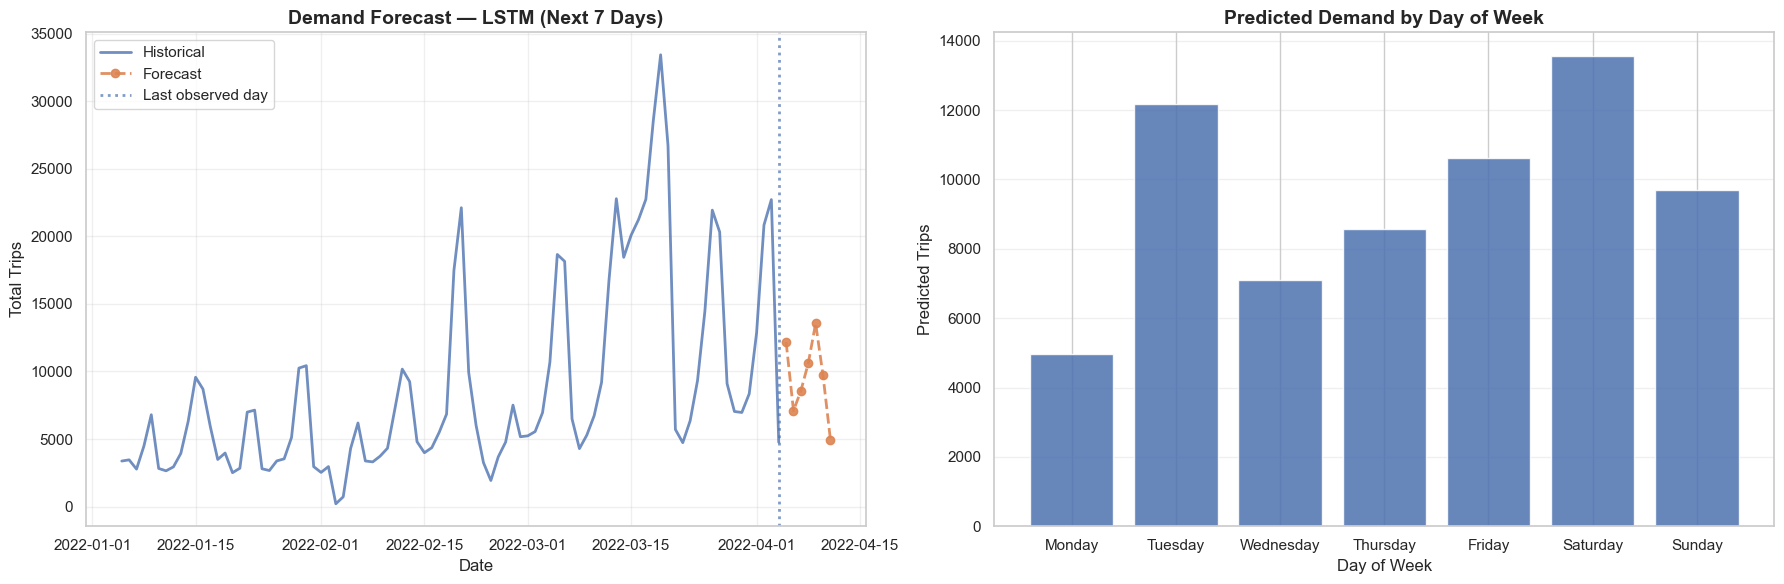


📊 LSTM Model Results:
   Weekly Total :     66,687 trips
   Daily Average:      9,527 trips
   Peak Day     :   Saturday (13,565 trips)
   Low Day      :     Monday (4,964 trips)

📁 Saved Files:
   • outputs/company_example_data.csv (input)
   • outputs/lstm_forecast_next_week.csv (forecast)


In [30]:
INFERENCE_MODEL = 'lstm'  # 'lstm' ή 'gru'

# Δημιουργήσαμε example input CSV από το processed daily dataset του Section 5. Αν υπάρχει ήδη το outputs/company_example_data.csv, χρησιμοποιούμε αυτό.
"""
print(f"\n📝 Preparing example company data...")

demo_data = pd.read_csv('data/processed/final_daily_micromobility_data.csv', parse_dates=['Date'])

# Kρατάμε σίγουρα Date + TotalTrips, και αν υπάρχουν οι υπόλοιπες raw cols τις κρατάμε
keep_cols = [c for c in ['Date', 'TotalTrips', 'TotalUniqueDevices', 'MedianDuration', 'MedianDistance'] if c in demo_data.columns]

company_data = demo_data[keep_cols].tail(90).copy()

os.makedirs('outputs', exist_ok=True)
company_data.to_csv('outputs/company_example_data.csv', index=False)

print(f" ✅ Created: outputs/company_example_data.csv ({len(company_data)} days) with cols={keep_cols}")
"""

# Εκτέλεση forecast
forecast = forecast_demand(csv_path='outputs/company_example_data.csv', model_type=INFERENCE_MODEL, plot=True)

# Αποθήκευση forecast
os.makedirs('outputs', exist_ok=True)
output_filename = f'outputs/{INFERENCE_MODEL}_forecast_next_week.csv'
forecast.to_csv(output_filename, index=False)

# Τελικό summary
print("\n" + "="*70)
print(f"📊 {INFERENCE_MODEL.upper()} Model Results:")
print(f"   Weekly Total : {forecast['Predicted_Trips'].sum():>10,.0f} trips")
print(f"   Daily Average: {forecast['Predicted_Trips'].mean():>10,.0f} trips")

peak_idx = forecast['Predicted_Trips'].idxmax()
low_idx  = forecast['Predicted_Trips'].idxmin()

print(f"   Peak Day     : {forecast.loc[peak_idx, 'DayOfWeek']:>10s} ({forecast.loc[peak_idx, 'Predicted_Trips']:,.0f} trips)")
print(f"   Low Day      : {forecast.loc[low_idx,  'DayOfWeek']:>10s} ({forecast.loc[low_idx,  'Predicted_Trips']:,.0f} trips)")

print("\n📁 Saved Files:")
print(f"   • outputs/company_example_data.csv (input)")
print(f"   • {output_filename} (forecast)")
print("="*70)